Import Libraries

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import pickle
import dlib
import numpy as np
import pandas as pd
import cv2
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
import random
from collections import Counter
from sklearn.model_selection import LeaveOneGroupOut
from scipy.signal import find_peaks
import statistics
from Utils.mean_average_precision.mean_average_precision import MeanAveragePrecision2d
random.seed(1)

In [2]:
dataset_name = 'SAMMLV' #Change to either 'CASME_sq' or 'SAMMLV' only
expression_type = 'macro-expression' #Change to either 'micro-expression' or 'macro-expression' only

Load dataset from pkl files processed from Extraction_Preprocess.ipynb

In [3]:
images = pickle.load( open( dataset_name + "_images_crop.pkl", "rb" ) )
subjectsVideos = pickle.load( open( dataset_name + "_subjectsVideos_crop.pkl", "rb" ) )
subjects = pickle.load( open( dataset_name + "_subjects_crop.pkl", "rb" ) )
dataset = pickle.load( open( dataset_name + "_dataset_" + expression_type + '.pkl', "rb" ) )

Read data from Excel file

In [4]:
if(dataset_name == 'CASME_sq'):
    xl = pd.ExcelFile(dataset_name + '/code_final.xlsx') #Specify directory of excel file

    colsName = ['subject', 'video', 'onset', 'apex', 'offset', 'au', 'emotion', 'type', 'selfReport']
    codeFinal = xl.parse(xl.sheet_names[0], header=None, names=colsName) #Get data

    videoNames = []
    for videoName in codeFinal.iloc[:,1]:
        videoNames.append(videoName.split('_')[0])
    codeFinal['videoName'] = videoNames

    naming1 = xl.parse(xl.sheet_names[2], header=None, converters={0: str})
    dictVideoName = dict(zip(naming1.iloc[:,1], naming1.iloc[:,0]))
    codeFinal['videoCode'] = [dictVideoName[i] for i in codeFinal['videoName']]

    naming2 = xl.parse(xl.sheet_names[1], header=None)
    dictSubject = dict(zip(naming2.iloc[:,2], naming2.iloc[:,1]))
    codeFinal['subjectCode'] = [dictSubject[i] for i in codeFinal['subject']]
    
elif(dataset_name=='SAMMLV'):
    xl = pd.ExcelFile(dataset_name + '/SAMM_LongVideos_V2_Release.xlsx')

    colsName = ['Subject', 'Filename', 'Inducement Code', 'Onset', 'Apex', 'Offset', 'Duration', 'Type', 'Action Units', 'Notes']
    codeFinal = xl.parse(xl.sheet_names[0], header=None, names=colsName, skiprows=[0,1,2,3,4,5,6,7,8,9])

    videoNames = []
    subjectName = []
    for videoName in codeFinal.iloc[:,1]:
        videoNames.append(str(videoName).split('_')[0] + '_' + str(videoName).split('_')[1])
        subjectName.append(str(videoName).split('_')[0])
    codeFinal['videoCode'] = videoNames
    codeFinal['subjectCode'] = subjectName
    #Synchronize the columns name with CAS(ME)^2
    codeFinal.rename(columns={'Type':'type', 'Onset':'onset', 'Offset':'offset', 'Apex':'apex'}, inplace=True) 
    
print('Data Columns:', codeFinal.columns) #Final data column

Data Columns: Index(['Subject', 'Filename', 'Inducement Code', 'onset', 'apex', 'offset',
       'Duration', 'type', 'Action Units', 'Notes', 'videoCode',
       'subjectCode'],
      dtype='object')


In [5]:
# Due to the different column name in excel file
dataset_expression_type = expression_type
if(dataset_name == 'SAMMLV' and expression_type=='micro-expression'):
    dataset_expression_type = 'Micro - 1/2'
elif(dataset_name == 'SAMMLV' and expression_type=='macro-expression'):
    dataset_expression_type = 'Macro'
    
vid_need = []
vid_count = 0
ground_truth = []
for sub_video_each_index, sub_vid_each in enumerate(subjectsVideos):
    ground_truth.append([])
    for videoIndex, videoCode in enumerate(sub_vid_each):
        on_off = []
        for i, row in codeFinal.iterrows():
            if (row['subjectCode']==subjects[sub_video_each_index]): #S15, S16... for CAS(ME)^2, 001, 002... for SAMMLV
                if (row['videoCode']==videoCode):
                    if (row['type']==dataset_expression_type): #Micro-expression or macro-expression
                        if (row['offset']==0): #Take apex if offset is 0
                            on_off.append([int(row['onset']-1), int(row['apex']-1)])
                        else:
                            if(dataset_expression_type!='Macro' or int(row['onset'])!=0): #Ignore the samples that is extremely long in SAMMLV
                                on_off.append([int(row['onset']-1), int(row['offset']-1)])
        if(len(on_off)>0):
            vid_need.append(vid_count) #To get the video that is needed
        ground_truth[-1].append(on_off) 
        vid_count+=1

#Remove unused video
final_samples = []
final_videos = []
final_subjects = []
count = 0
for subjectIndex, subject in enumerate(ground_truth):
    final_samples.append([])
    final_videos.append([])
    for samplesIndex, samples in enumerate(subject):
        if (count in vid_need):
            final_samples[-1].append(samples)
            final_videos[-1].append(subjectsVideos[subjectIndex][samplesIndex])
            final_subjects.append(subjects[subjectIndex])
        count += 1

#Remove the empty data in array
final_subjects = np.unique(final_subjects)
final_videos = [ele for ele in final_videos if ele != []]
final_samples = [ele for ele in final_samples if ele != []]
final_images = [images[i] for i in vid_need]
print('Final Ground Truth Data')
print('Subjects Name', final_subjects)
print('Videos Name: ', final_videos)
print('Samples [Onset, Offset]: ', final_samples)
print('Total Videos:', len(final_images))

Final Ground Truth Data
Subjects Name ['006' '007' '008' '009' '010' '011' '012' '013' '014' '015' '016' '017'
 '018' '019' '020' '021' '022' '023' '024' '025' '026' '028' '030' '032'
 '033' '034' '035' '036' '037']
Videos Name:  [['006_1', '006_2', '006_3', '006_4', '006_5', '006_6', '006_7'], ['007_5', '007_6', '007_7'], ['008_1', '008_5', '008_6', '008_7'], ['009_3', '009_4', '009_6', '009_7'], ['010_1', '010_2', '010_3', '010_4', '010_5', '010_6', '010_7'], ['011_1', '011_2', '011_3', '011_4', '011_5', '011_6', '011_7'], ['012_3', '012_4', '012_5', '012_6', '012_7'], ['013_1', '013_2', '013_3', '013_6', '013_7'], ['014_1', '014_2', '014_3', '014_4', '014_5', '014_6', '014_7'], ['015_1', '015_3', '015_5', '015_6', '015_7'], ['016_1', '016_2', '016_4', '016_5', '016_6', '016_7'], ['017_1', '017_2', '017_3', '017_4', '017_5', '017_6'], ['018_2', '018_3', '018_4', '018_5', '018_6', '018_7'], ['019_1', '019_2', '019_3', '019_5', '019_7'], ['020_1', '020_2', '020_3', '020_4', '020_5', '0

Get k (Average length of half of an expression) from the chosen Macro- or Micro-Expression

In [6]:
#CAS(ME)^2
#Micro-Expression: N=12, k=6
#Macro-Expression: N=35, k=18

#SAMMLV
#Micro-Expression: N=73, k=37
#Macro-Expression: N=348, k=174

samples = [samples for subjects in final_samples for videos in subjects for samples in videos]
total_duration = 0
for sample in samples:
    total_duration += sample[1]-sample[0]
N=total_duration/len(samples)
k=int((N+1)/2)
print(dataset_name, expression_type)
print('k =',k)

SAMMLV macro-expression
k = 174


Pseudo-labeling using Unit Step Function

In [7]:
pseudo_y = []
video_count = 0 

for subject in final_samples:
    for video in subject:
        samples_arr = []
        if (len(video)==0):
            pseudo_y.append([0 for i in range(len(final_images[video_count])-k)]) #Last k frames are ignored
        else:
            pseudo_y_each = [0]*(len(final_images[video_count])-k)
            for ME in video:
                samples_arr.append(np.arange(ME[0]+1, ME[1]+1))
            for ground_truth_arr in samples_arr: 
                for index in range(len(pseudo_y_each)):
                    pseudo_arr = np.arange(index, index+k) 
                    # Equivalent to if IoU>0 then y=1, else y=0
                    if (pseudo_y_each[index] < len(np.intersect1d(pseudo_arr, ground_truth_arr))/len(np.union1d(pseudo_arr, ground_truth_arr))):
                        pseudo_y_each[index] = 1 
            pseudo_y.append(pseudo_y_each)
        video_count+=1

# Integrate all videos into one dataset
pseudo_y = [y for x in pseudo_y for y in x]
print('Total frames:', len(pseudo_y))

Total frames: 435891


Prepare X and y for model training and testing

In [8]:
#To split the dataset by subjects
y = np.array(pseudo_y)
videos_len = []
groupsLabel = y.copy()
prevIndex = 0
countVideos = 0

#Get total frames of each video
for video_index in range(len(final_images)):
  videos_len.append(final_images[video_index].shape[0]-k)

print('Frame Index for each subject:-')
for video_index in range(len(final_samples)):
  countVideos += len(final_samples[video_index])
  index = sum(videos_len[:countVideos])
  groupsLabel[prevIndex:index] = video_index
  print('Subject', video_index, ':', prevIndex, '->', index)
  prevIndex = index

X = [frame for video in dataset for frame in video]
print('\nTotal X:', len(X), ', Total y:', len(y))

Frame Index for each subject:-
Subject 0 : 0 -> 29081
Subject 1 : 29081 -> 42559
Subject 2 : 42559 -> 50754
Subject 3 : 50754 -> 55754
Subject 4 : 55754 -> 73809
Subject 5 : 73809 -> 116343
Subject 6 : 116343 -> 130128
Subject 7 : 130128 -> 150935
Subject 8 : 150935 -> 178694
Subject 9 : 178694 -> 192961
Subject 10 : 192961 -> 211642
Subject 11 : 211642 -> 220101
Subject 12 : 220101 -> 242609
Subject 13 : 242609 -> 256740
Subject 14 : 256740 -> 287764
Subject 15 : 287764 -> 291009
Subject 16 : 291009 -> 300721
Subject 17 : 300721 -> 301548
Subject 18 : 301548 -> 306729
Subject 19 : 306729 -> 311882
Subject 20 : 311882 -> 325255
Subject 21 : 325255 -> 327082
Subject 22 : 327082 -> 337061
Subject 23 : 337061 -> 351827
Subject 24 : 351827 -> 369894
Subject 25 : 369894 -> 377547
Subject 26 : 377547 -> 399371
Subject 27 : 399371 -> 420193
Subject 28 : 420193 -> 435891

Total X: 435891 , Total y: 435891


**SoftNet Training and Testing**

In [9]:
# Use GPU
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [10]:
def normalize(images):
    for index in range(len(images)):
        for channel in range(3):
            images[index][:,:,channel] = cv2.normalize(images[index][:,:,channel], None, alpha=0, beta=1,norm_type=cv2.NORM_MINMAX)
    return images

def generator(X, y, batch_size=12, epochs=1):
    while True:
        for start in range(0, len(X), batch_size):
            end = min(start + batch_size, len(X))
            num_images = end - start
            X[start:end] = normalize(X[start:end])
            u = np.array(X[start:end])[:,:,:,0].reshape(num_images,42,42,1)
            v = np.array(X[start:end])[:,:,:,1].reshape(num_images,42,42,1)
            os = np.array(X[start:end])[:,:,:,2].reshape(num_images,42,42,1)
            yield [u, v, os], np.array(y[start:end])
            
def shuffling(X, y):
    shuf = list(zip(X, y))
    random.shuffle(shuf)
    X, y = zip(*shuf)
    return list(X), list(y)

def data_augmentation(X, y):
    transformations = {
        0: lambda image: np.fliplr(image), 
        1: lambda image: cv2.GaussianBlur(image, (7,7), 0),
        2: lambda image: random_noise(image),
    }
    y1=y.copy()
    for index, label in enumerate(y1):
        if (label==1): #Only augment on expression samples (label=1)
            for augment_type in range(3):
                img_transformed = transformations[augment_type](X[index]).reshape(42,42,3)
                X.append(np.array(img_transformed))
                y.append(1)
    return X, y

In [11]:
def SOFTNet():
    inputs1 = layers.Input(shape=(42,42,1))
    conv1 = layers.Conv2D(3, (5,5), padding='same', activation='relu')(inputs1)
    pool1 = layers.MaxPooling2D(pool_size=(3, 3), strides=(3,3))(conv1)
    # channel 2
    inputs2 = layers.Input(shape=(42,42,1))
    conv2 = layers.Conv2D(5, (5,5), padding='same', activation='relu')(inputs2)
    pool2 = layers.MaxPooling2D(pool_size=(3, 3), strides=(3,3))(conv2)
    # channel 3
    inputs3 = layers.Input(shape=(42,42,1))
    conv3 = layers.Conv2D(8, (5,5), padding='same', activation='relu')(inputs3)
    pool3 = layers.MaxPooling2D(pool_size=(3, 3), strides=(3,3))(conv3)
    # merge
    merged = layers.Concatenate()([pool1, pool2, pool3])
    # interpretation
    merged_pool = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(merged)
    flat = layers.Flatten()(merged_pool)
    dense = layers.Dense(400, activation='relu')(flat)
    outputs = layers.Dense(1, activation='linear')(dense)
    #Takes input u,v,s
    model = keras.models.Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    sgd = keras.optimizers.SGD(lr=0.0005)
    model.compile(loss="mse", optimizer=sgd, metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return model

def spotting(result, total_gt):
    prev=0
    for videoIndex, video in enumerate(final_samples[subject_count-1]):
        preds = []
        gt = []
        countVideo = len([video for subject in final_samples[:subject_count-1] for video in subject])
        print('Video:', countVideo+videoIndex)
        score_plot = np.array(result[prev:prev+len(dataset[countVideo+videoIndex])]) #Get related frames to each video
        score_plot_agg = score_plot.copy()
        
        #Score aggregation
        for x in range(len(score_plot[k:-k])):
            score_plot_agg[x+k] = score_plot[x:x+2*k].mean()
        score_plot_agg = score_plot_agg[k:-k]
        
        #Plot the result to see the peaks
        #Note for some video the ground truth samples is below frame index 0 due to the effect of aggregation, but no impact to the evaluation
        plt.figure(figsize=(15,4))
        plt.plot(score_plot_agg) 
        plt.xlabel('Frame')
        plt.ylabel('Score')
        threshold = score_plot_agg.mean() + p * (max(score_plot_agg) - score_plot_agg.mean()) #Moilanen threshold technique
        peaks, _ = find_peaks(score_plot_agg[:,0], height=threshold[0], distance=k)
        if(len(peaks)==0): #Occurs when no peak is detected, simply give a value to pass the exception in mean_average_precision
            preds.append([0, 0, 0, 0, 0, 0]) 
        for peak in peaks:
            preds.append([peak-k, 0, peak+k, 0, 0, 0]) #Extend left and right side of peak by k frames
        for samples in video:
            gt.append([samples[0]-k, 0, samples[1]-k, 0, 0, 0, 0])
            total_gt += 1
            plt.axvline(x=samples[0]-k, color='r')
            plt.axvline(x=samples[1]-k+1, color='r')
            plt.axhline(y=threshold, color='g')
        plt.show()
        prev += len(dataset[countVideo+videoIndex])
        metric_fn.add(np.array(preds),np.array(gt)) #IoU = 0.5 according to MEGC2020 metrics
    return preds, gt, total_gt
        
def evaluation(preds, gt, total_gt): #Get TP, FP, FN for final evaluation
    TP = int(sum(metric_fn.value(iou_thresholds=0.5)[0.5][0]['tp'])) 
    FP = int(sum(metric_fn.value(iou_thresholds=0.5)[0.5][0]['fp']))
    FN = total_gt - TP
    print('TP:', TP, 'FP:', FP, 'FN:', FN)
    return TP, FP, FN

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1

Subject : 1
Dataset Labels Counter({0: 266162, 1: 140648})
After Downsampling Dataset Labels Counter({1: 140648, 0: 133081})
------Initializing SOFTNet-------
Epoch 1/10
22811/22810 [==============================] - 73s 3ms/step - loss: 0.2036 - mean_absolute_error: 0.4100 - val_loss: 0.2488 - val_mean_absolute_error: 0.4636
Epoch 2/10
22811/22810 [==============================] - 72s 3ms/step - loss: 0.1894 - mean_absolute_error: 0.3871 - val_loss: 0.2460 - val_mean_absolute_error: 0.4583
Epoch 3/10
22811/22810 [==============================] - 72s 3ms/step - loss: 0.1855 - mean_absolute_error: 0.3804 - val_loss: 0.243

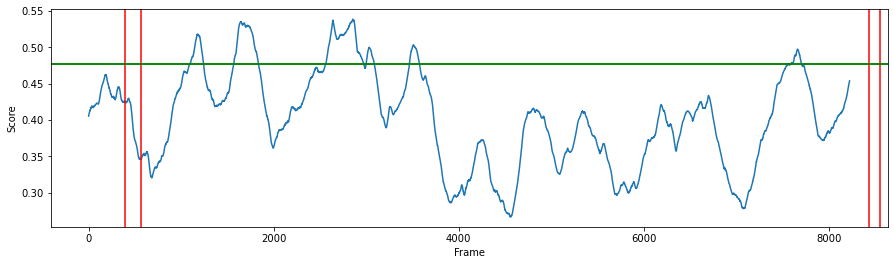

Video: 1


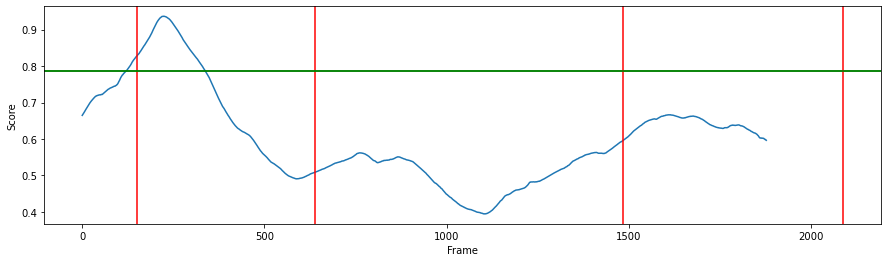

Video: 2


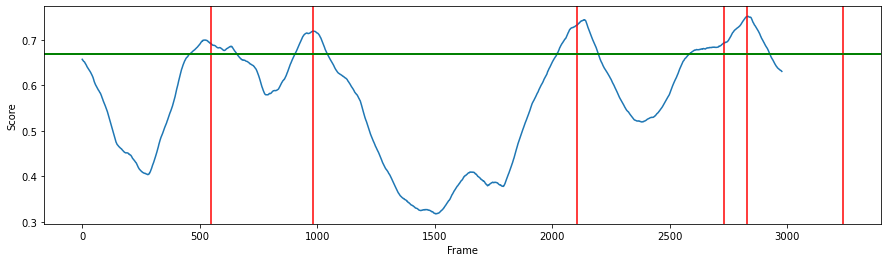

Video: 3


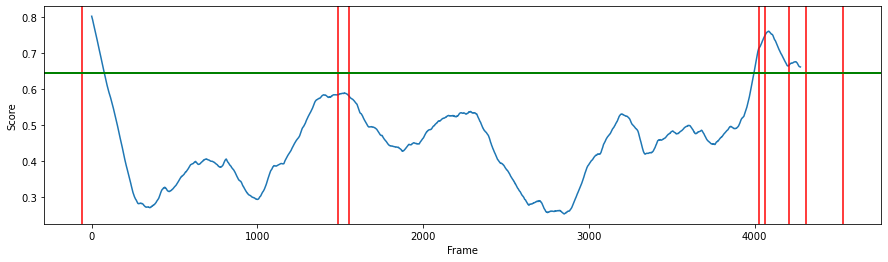

Video: 4


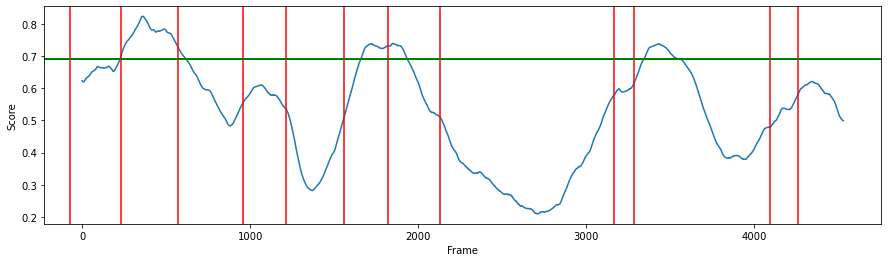

Video: 5


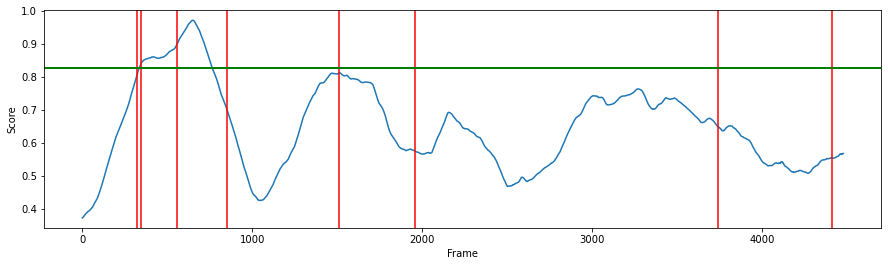

Video: 6


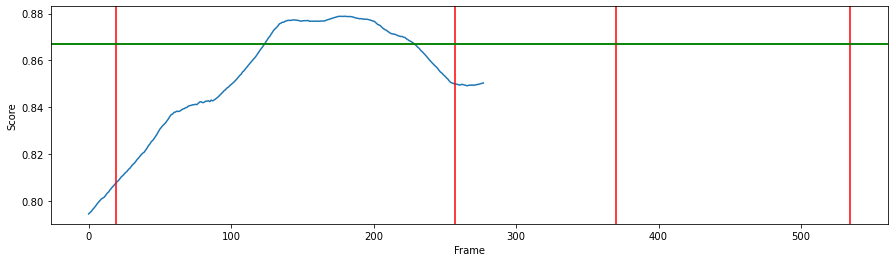

TP: 4 FP: 17 FN: 19
Done Subject 1
Subject : 2
Dataset Labels Counter({0: 271287, 1: 151126})
After Downsampling Dataset Labels Counter({1: 151126, 0: 135643})
------Initializing SOFTNet-------
Epoch 1/10
23898/23897 [==============================] - 73s 3ms/step - loss: 0.2040 - mean_absolute_error: 0.4123 - val_loss: 0.2568 - val_mean_absolute_error: 0.4658
Epoch 2/10
23898/23897 [==============================] - 73s 3ms/step - loss: 0.1884 - mean_absolute_error: 0.3866 - val_loss: 0.2614 - val_mean_absolute_error: 0.4661
Epoch 3/10
23898/23897 [==============================] - 72s 3ms/step - loss: 0.1836 - mean_absolute_error: 0.3782 - val_loss: 0.2648 - val_mean_absolute_error: 0.4667
Epoch 4/10
23898/23897 [==============================] - 72s 3ms/step - loss: 0.1799 - mean_absolute_error: 0.3721 - val_loss: 0.2669 - val_mean_absolute_error: 0.4665
Epoch 5/10
23898/23897 [==============================] - 73s 3ms/step - loss: 0.1767 - mean_absolute_error: 0.3667 - val_loss: 0.

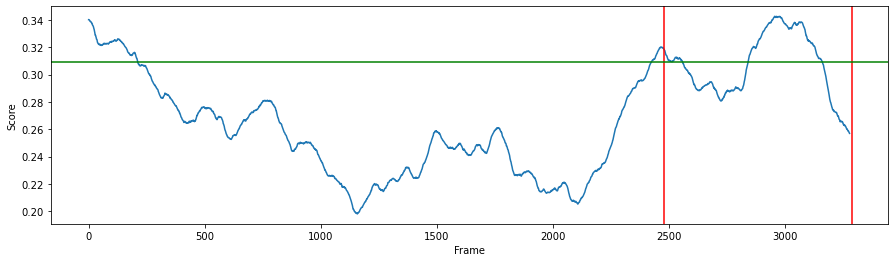

Video: 8


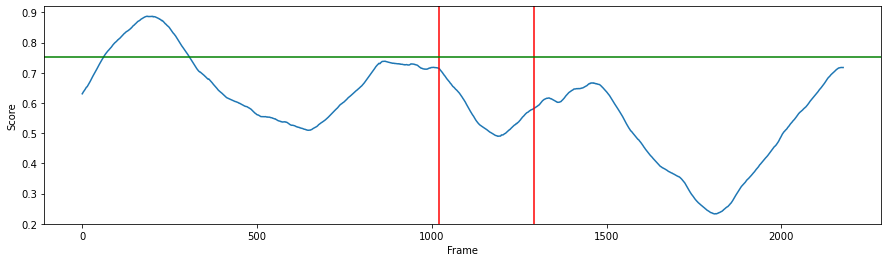

Video: 9


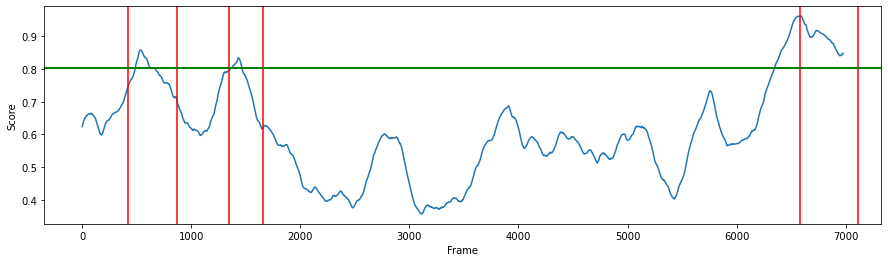

TP: 7 FP: 25 FN: 21
Done Subject 2
Subject : 3
Dataset Labels Counter({0: 275488, 1: 152208})
After Downsampling Dataset Labels Counter({1: 152208, 0: 137744})
------Initializing SOFTNet-------
Epoch 1/10
24163/24162 [==============================] - 69s 3ms/step - loss: 0.2041 - mean_absolute_error: 0.4124 - val_loss: 0.1790 - val_mean_absolute_error: 0.3660
Epoch 2/10
24163/24162 [==============================] - 69s 3ms/step - loss: 0.1885 - mean_absolute_error: 0.3865 - val_loss: 0.1785 - val_mean_absolute_error: 0.3612
Epoch 3/10
24163/24162 [==============================] - 69s 3ms/step - loss: 0.1836 - mean_absolute_error: 0.3780 - val_loss: 0.1775 - val_mean_absolute_error: 0.3570
Epoch 4/10
24163/24162 [==============================] - 70s 3ms/step - loss: 0.1798 - mean_absolute_error: 0.3718 - val_loss: 0.1769 - val_mean_absolute_error: 0.3528
Epoch 5/10
24163/24162 [==============================] - 70s 3ms/step - loss: 0.1765 - mean_absolute_error: 0.3663 - val_loss: 0.

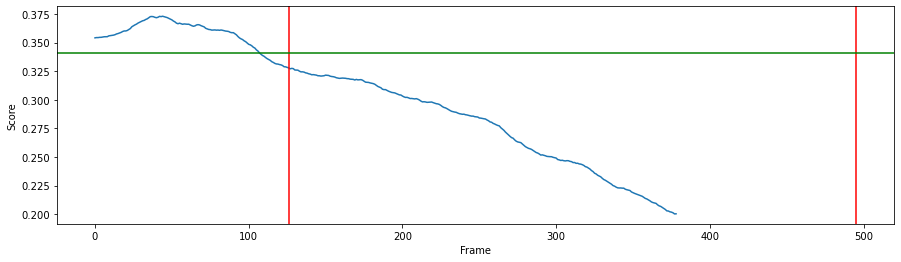

Video: 11


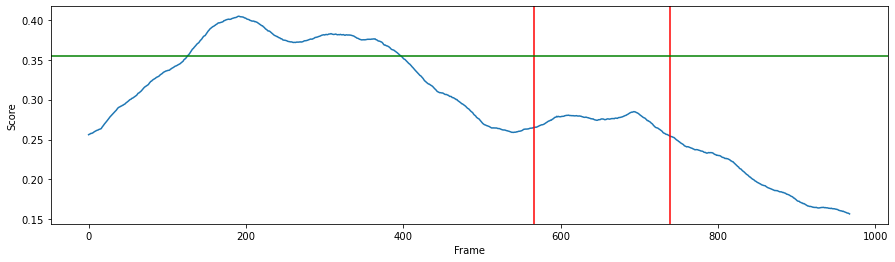

Video: 12


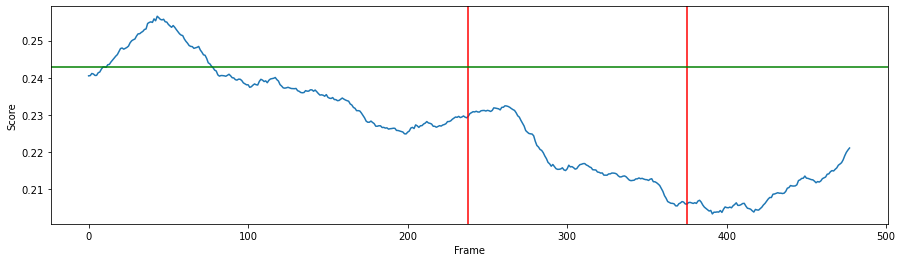

Video: 13


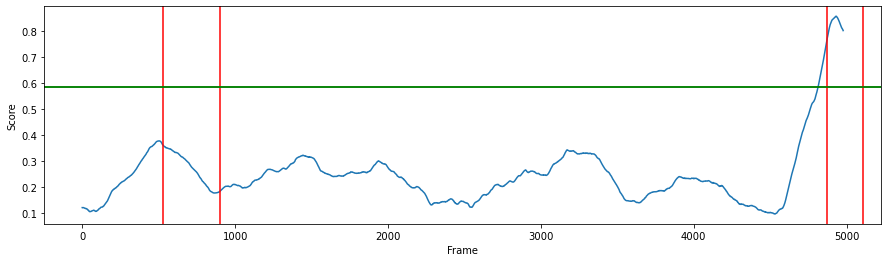

TP: 8 FP: 29 FN: 25
Done Subject 3
Subject : 4
Dataset Labels Counter({0: 278578, 1: 152313})
After Downsampling Dataset Labels Counter({1: 152313, 0: 139289})
------Initializing SOFTNet-------
Epoch 1/10
24301/24300 [==============================] - 71s 3ms/step - loss: 0.2039 - mean_absolute_error: 0.4120 - val_loss: 0.2767 - val_mean_absolute_error: 0.5036
Epoch 2/10
24301/24300 [==============================] - 71s 3ms/step - loss: 0.1883 - mean_absolute_error: 0.3864 - val_loss: 0.2786 - val_mean_absolute_error: 0.4972
Epoch 3/10
24301/24300 [==============================] - 69s 3ms/step - loss: 0.1834 - mean_absolute_error: 0.3780 - val_loss: 0.2796 - val_mean_absolute_error: 0.4941
Epoch 4/10
24301/24300 [==============================] - 69s 3ms/step - loss: 0.1796 - mean_absolute_error: 0.3718 - val_loss: 0.2797 - val_mean_absolute_error: 0.4918
Epoch 5/10
24301/24300 [==============================] - 69s 3ms/step - loss: 0.1763 - mean_absolute_error: 0.3662 - val_loss: 0.

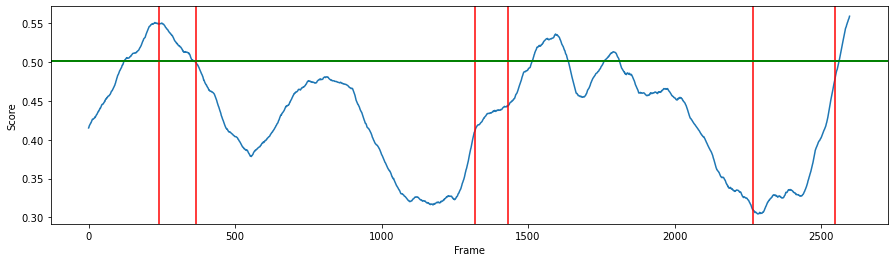

Video: 15


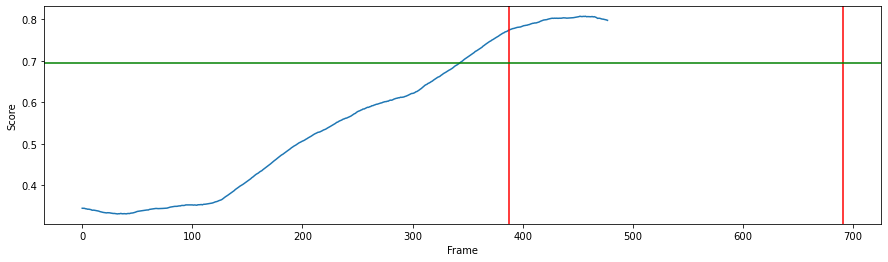

Video: 16


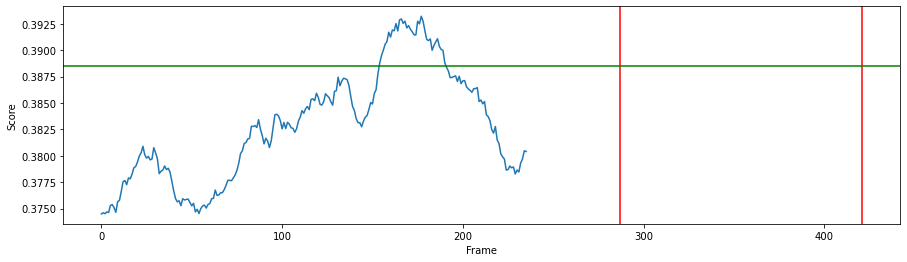

Video: 17


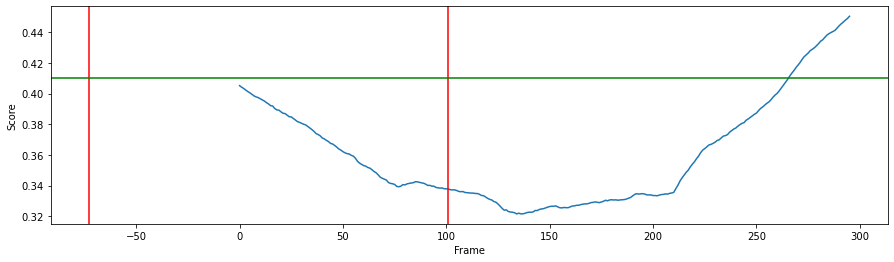

TP: 9 FP: 34 FN: 30
Done Subject 4
Subject : 5
Dataset Labels Counter({0: 271372, 1: 146464})
After Downsampling Dataset Labels Counter({1: 146464, 0: 135686})
------Initializing SOFTNet-------
Epoch 1/10
23513/23512 [==============================] - 69s 3ms/step - loss: 0.2044 - mean_absolute_error: 0.4129 - val_loss: 0.1889 - val_mean_absolute_error: 0.3904
Epoch 2/10
23513/23512 [==============================] - ETA: 37s - loss: 0.1877 - mean_absolute_error: 0.385 - 70s 3ms/step - loss: 0.1886 - mean_absolute_error: 0.3861 - val_loss: 0.1901 - val_mean_absolute_error: 0.3875
Epoch 3/10
23513/23512 [==============================] - 69s 3ms/step - loss: 0.1839 - mean_absolute_error: 0.3780 - val_loss: 0.1907 - val_mean_absolute_error: 0.3876
Epoch 4/10
23513/23512 [==============================] - 69s 3ms/step - loss: 0.1803 - mean_absolute_error: 0.3721 - val_loss: 0.1908 - val_mean_absolute_error: 0.3876
Epoch 5/10
23513/23512 [==============================] - 69s 3ms/step - lo

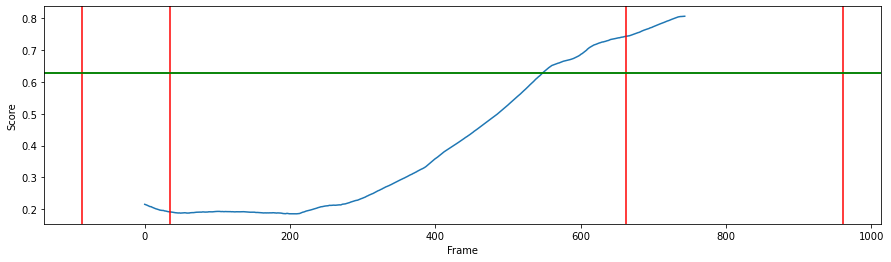

Video: 19


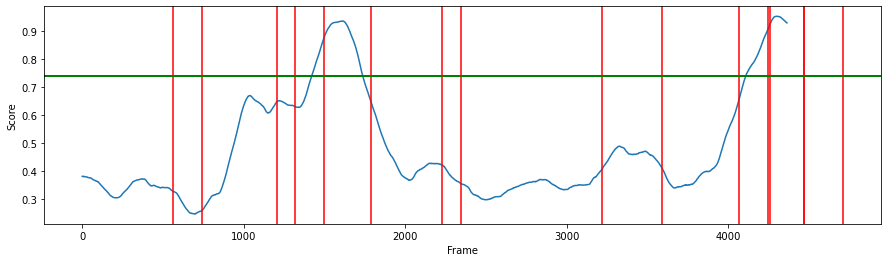

Video: 20


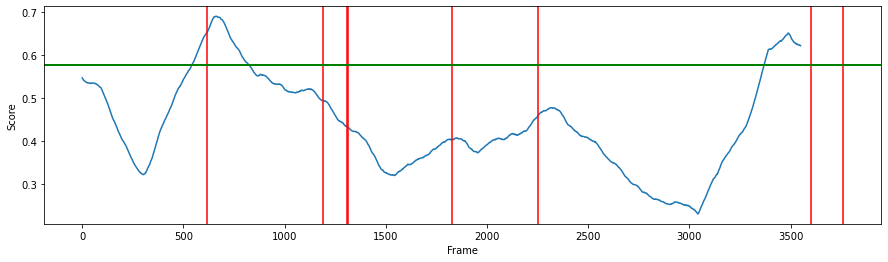

Video: 21


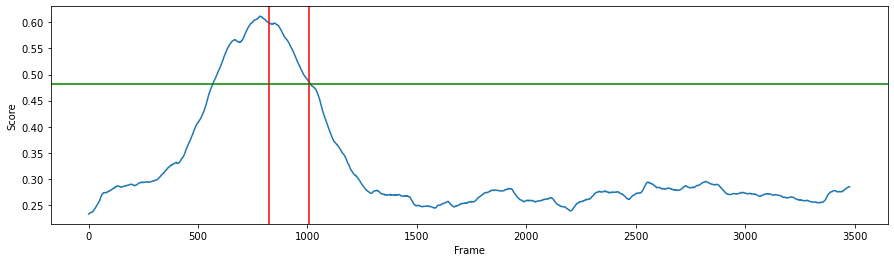

Video: 22


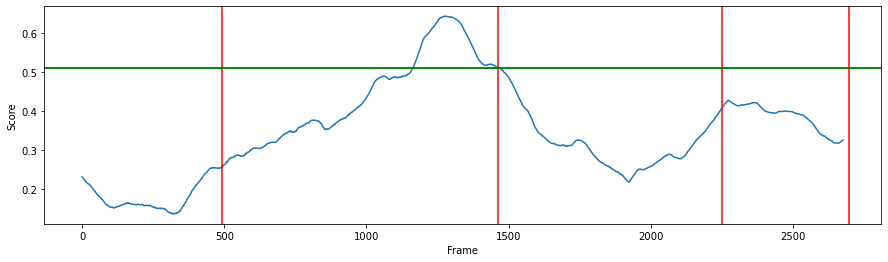

Video: 23


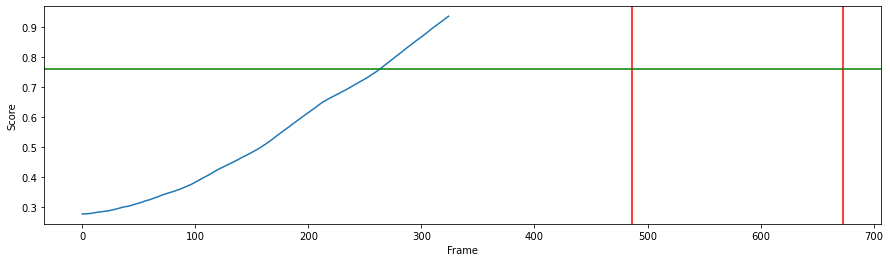

Video: 24


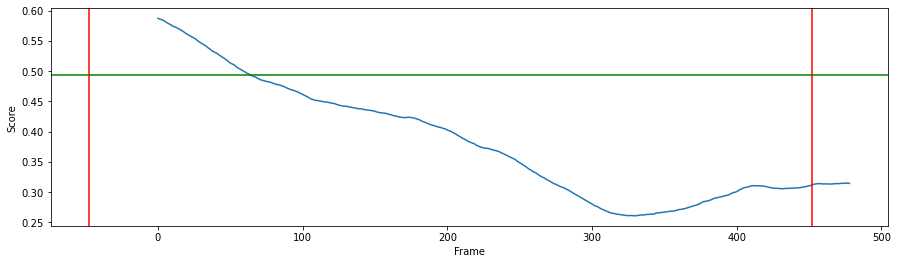

TP: 12 FP: 42 FN: 46
Done Subject 5
Subject : 6
Dataset Labels Counter({0: 259861, 1: 133496})
After Downsampling Dataset Labels Counter({1: 133496, 0: 129930})
------Initializing SOFTNet-------
Epoch 1/10
21953/21952 [==============================] - 68s 3ms/step - loss: 0.2079 - mean_absolute_error: 0.4192 - val_loss: 0.2241 - val_mean_absolute_error: 0.4264
Epoch 2/10
21953/21952 [==============================] - 68s 3ms/step - loss: 0.1910 - mean_absolute_error: 0.3913 - val_loss: 0.2304 - val_mean_absolute_error: 0.4294
Epoch 3/10
21953/21952 [==============================] - 69s 3ms/step - loss: 0.1857 - mean_absolute_error: 0.3822 - val_loss: 0.2357 - val_mean_absolute_error: 0.4321
Epoch 4/10
21953/21952 [==============================] - 68s 3ms/step - loss: 0.1818 - mean_absolute_error: 0.3757 - val_loss: 0.2410 - val_mean_absolute_error: 0.4344
Epoch 5/10
21953/21952 [==============================] - 68s 3ms/step - loss: 0.1784 - mean_absolute_error: 0.3701 - val_loss: 0

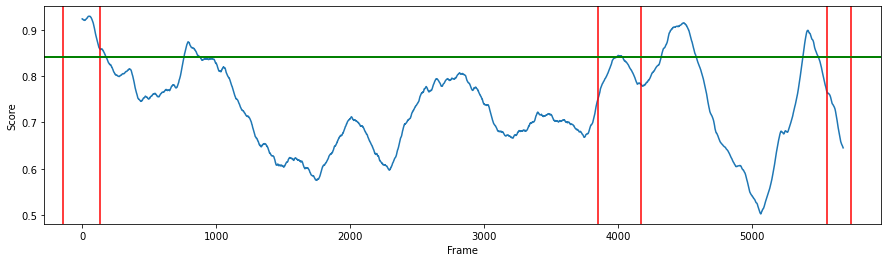

Video: 26


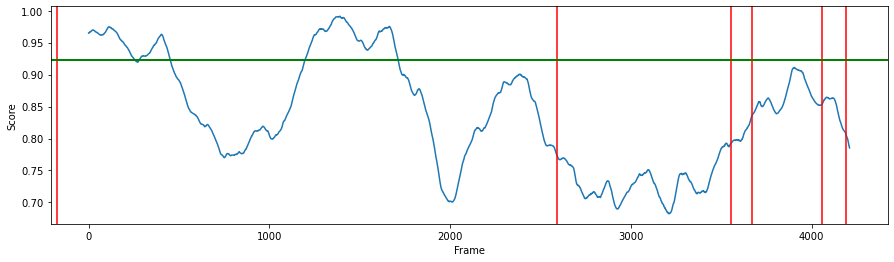

Video: 27


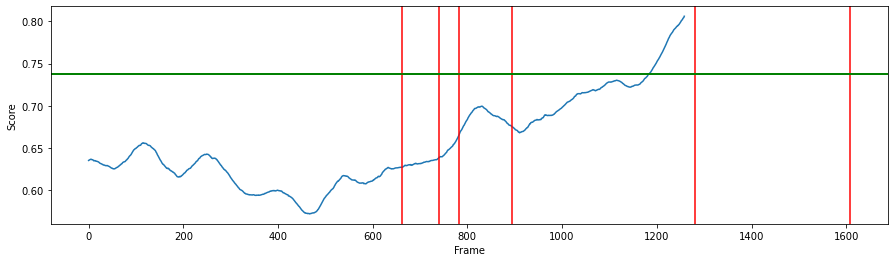

Video: 28


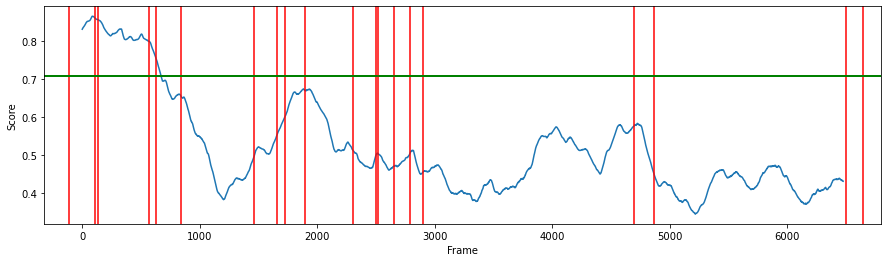

Video: 29


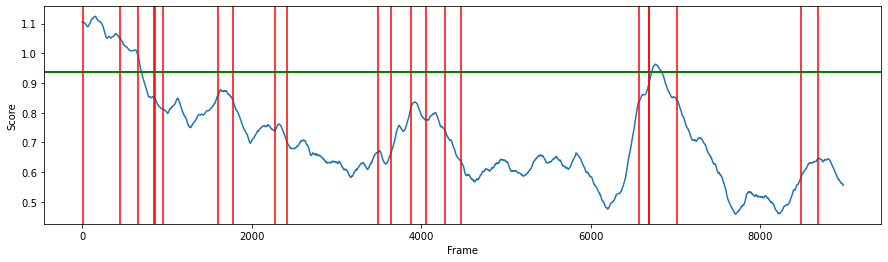

Video: 30


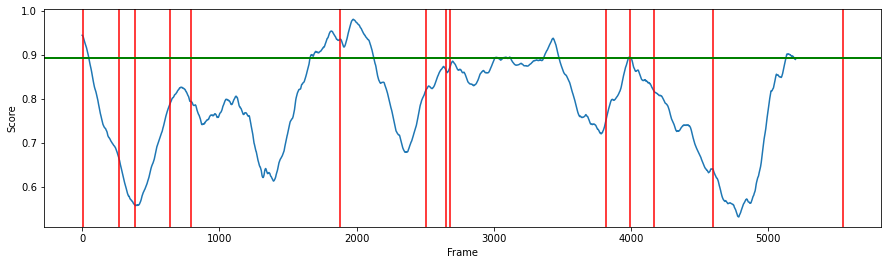

Video: 31


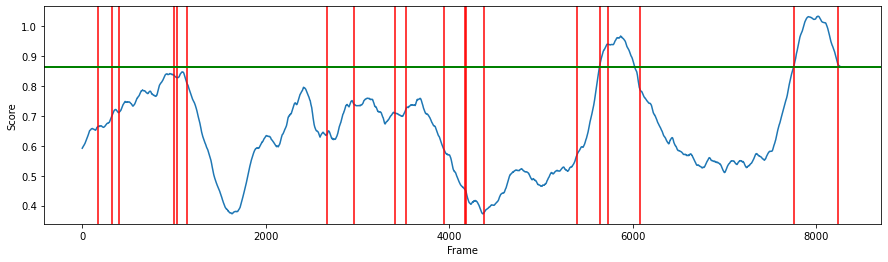

TP: 20 FP: 60 FN: 85
Done Subject 6
Subject : 7
Dataset Labels Counter({0: 270543, 1: 151563})
After Downsampling Dataset Labels Counter({1: 151563, 0: 135271})
------Initializing SOFTNet-------
Epoch 1/10
23903/23902 [==============================] - 70s 3ms/step - loss: 0.2055 - mean_absolute_error: 0.4149 - val_loss: 0.1559 - val_mean_absolute_error: 0.3609
Epoch 2/10
23903/23902 [==============================] - 70s 3ms/step - loss: 0.1901 - mean_absolute_error: 0.3896 - val_loss: 0.1477 - val_mean_absolute_error: 0.3403
Epoch 3/10
23903/23902 [==============================] - 70s 3ms/step - loss: 0.1852 - mean_absolute_error: 0.3813 - val_loss: 0.1435 - val_mean_absolute_error: 0.3276
Epoch 4/10
23903/23902 [==============================] - 70s 3ms/step - loss: 0.1814 - mean_absolute_error: 0.3751 - val_loss: 0.1419 - val_mean_absolute_error: 0.3206
Epoch 5/10
23903/23902 [==============================] - 70s 3ms/step - loss: 0.1780 - mean_absolute_error: 0.3695 - val_loss: 0

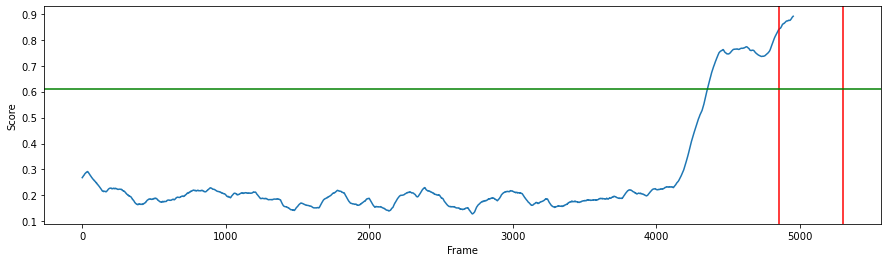

Video: 33


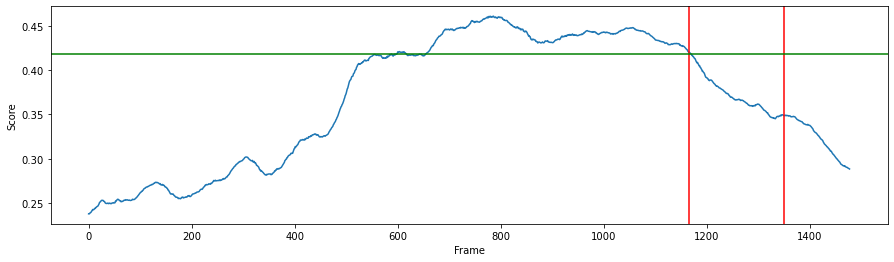

Video: 34


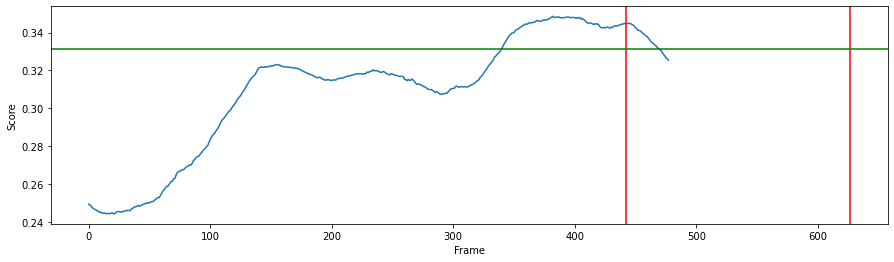

Video: 35


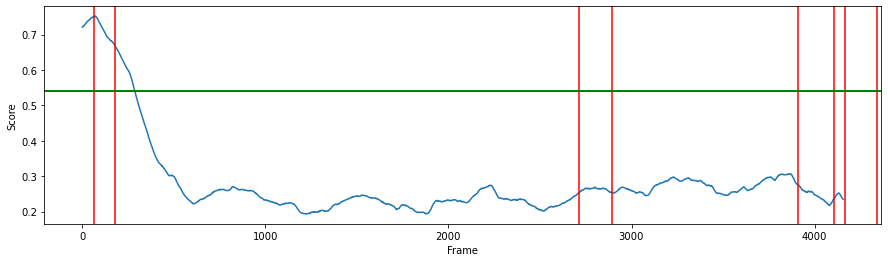

Video: 36


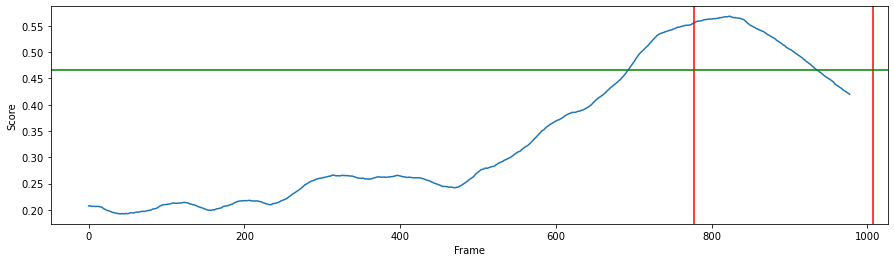

TP: 21 FP: 68 FN: 92
Done Subject 7
Subject : 8
Dataset Labels Counter({0: 265683, 1: 149401})
After Downsampling Dataset Labels Counter({1: 149401, 0: 132841})
------Initializing SOFTNet-------
Epoch 1/10
23521/23520 [==============================] - 69s 3ms/step - loss: 0.2039 - mean_absolute_error: 0.4119 - val_loss: 0.1871 - val_mean_absolute_error: 0.4063
Epoch 2/10
23521/23520 [==============================] - 69s 3ms/step - loss: 0.1878 - mean_absolute_error: 0.3853 - val_loss: 0.1870 - val_mean_absolute_error: 0.4032
Epoch 3/10
23521/23520 [==============================] - 69s 3ms/step - loss: 0.1830 - mean_absolute_error: 0.3769 - val_loss: 0.1869 - val_mean_absolute_error: 0.4021
Epoch 4/10
23521/23520 [==============================] - ETA: 38s - loss: 0.1867 - mean_absolute_error: 0.400 - 69s 3ms/step - loss: 0.1792 - mean_absolute_error: 0.3708 - val_loss: 0.1864 - val_mean_absolute_error: 0.4003
Epoch 5/10
23521/23520 [==============================] - 68s 3ms/step - l

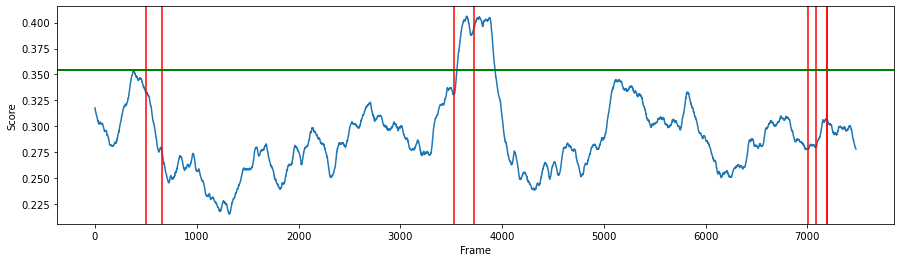

Video: 38


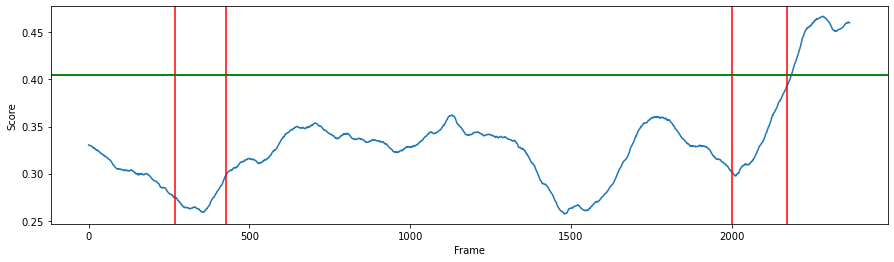

Video: 39


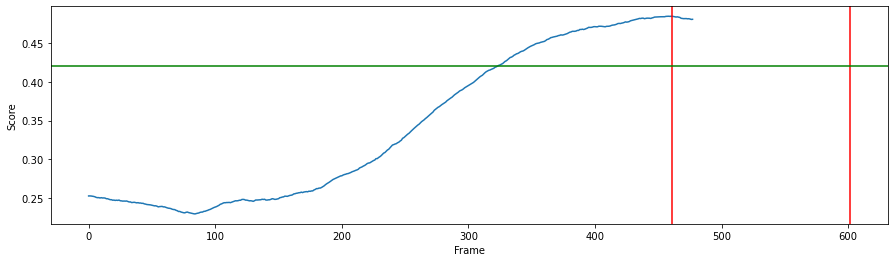

Video: 40


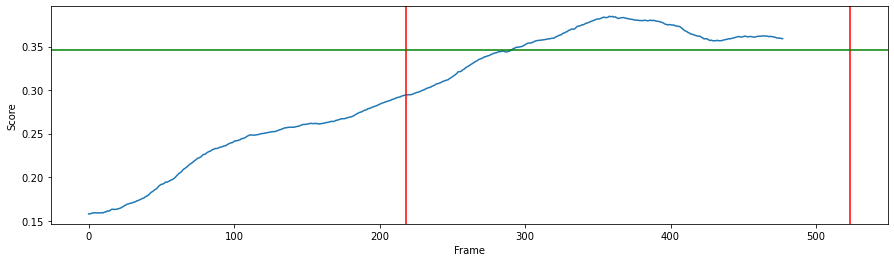

Video: 41


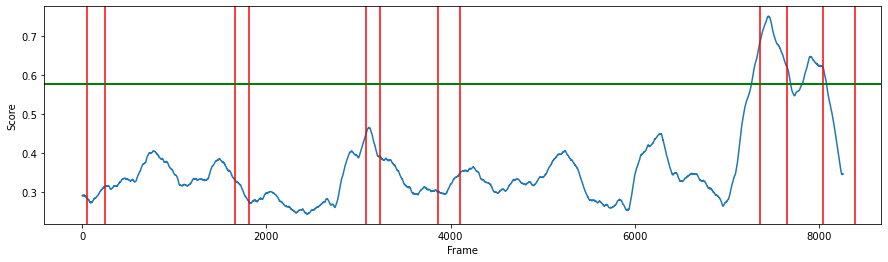

TP: 24 FP: 73 FN: 103
Done Subject 8
Subject : 9
Dataset Labels Counter({0: 261579, 1: 146553})
After Downsampling Dataset Labels Counter({1: 146553, 0: 130789})
------Initializing SOFTNet-------
Epoch 1/10
23112/23111 [==============================] - 69s 3ms/step - loss: 0.2032 - mean_absolute_error: 0.4106 - val_loss: 0.2723 - val_mean_absolute_error: 0.4809
Epoch 2/10
23112/23111 [==============================] - 69s 3ms/step - loss: 0.1881 - mean_absolute_error: 0.3859 - val_loss: 0.2636 - val_mean_absolute_error: 0.4710
Epoch 3/10
23112/23111 [==============================] - 69s 3ms/step - loss: 0.1832 - mean_absolute_error: 0.3776 - val_loss: 0.2628 - val_mean_absolute_error: 0.4689
Epoch 4/10
23112/23111 [==============================] - 69s 3ms/step - loss: 0.1795 - mean_absolute_error: 0.3713 - val_loss: 0.2647 - val_mean_absolute_error: 0.4697
Epoch 5/10
23112/23111 [==============================] - 69s 3ms/step - loss: 0.1761 - mean_absolute_error: 0.3657 - val_loss: 

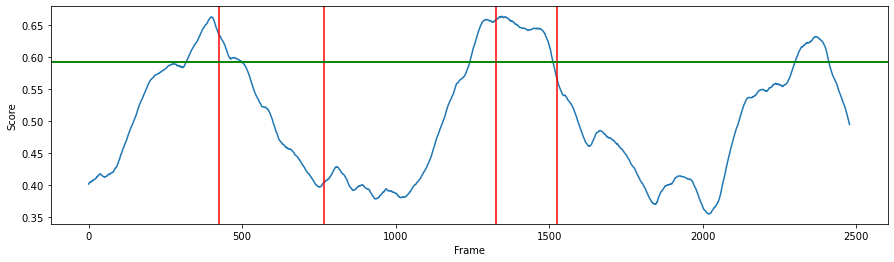

Video: 43


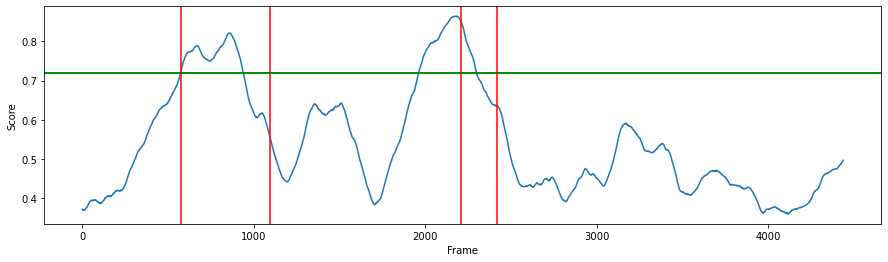

Video: 44


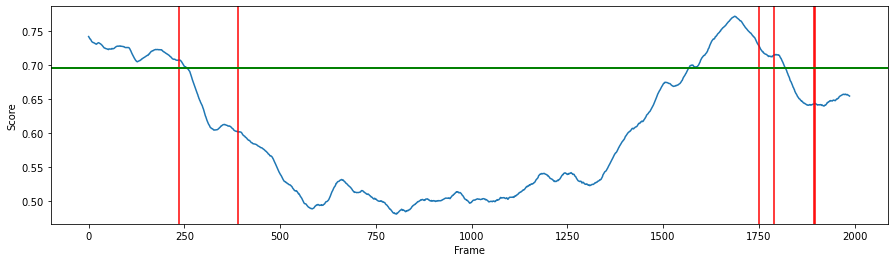

Video: 45


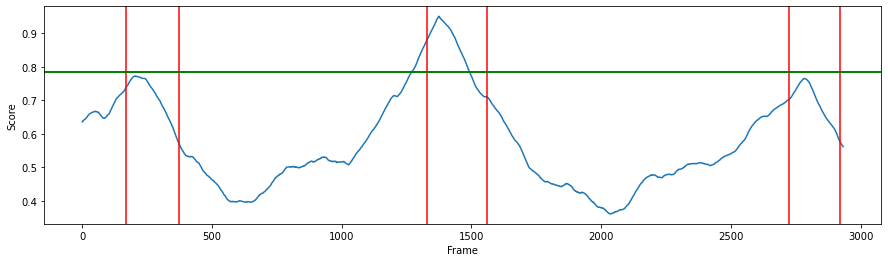

Video: 46


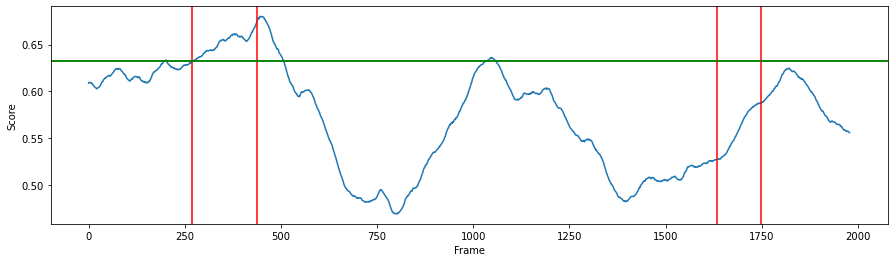

Video: 47


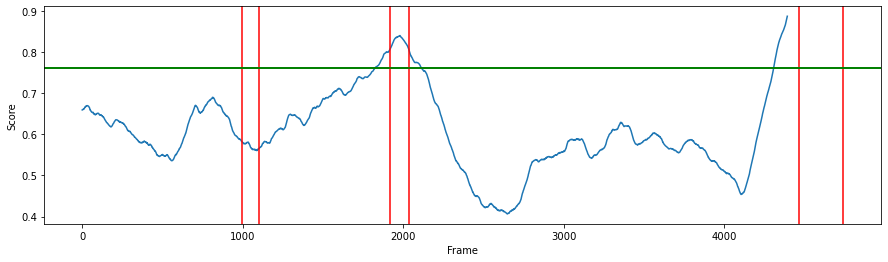

Video: 48


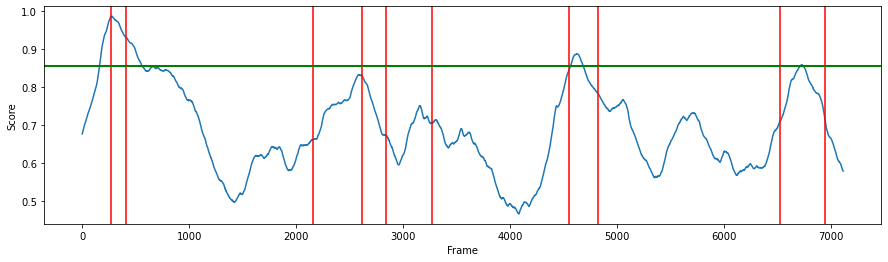

TP: 29 FP: 87 FN: 118
Done Subject 9
Subject : 10
Dataset Labels Counter({0: 272689, 1: 148935})
After Downsampling Dataset Labels Counter({1: 148935, 0: 136344})
------Initializing SOFTNet-------
Epoch 1/10
23774/23773 [==============================] - 69s 3ms/step - loss: 0.2040 - mean_absolute_error: 0.4119 - val_loss: 0.2027 - val_mean_absolute_error: 0.4225
Epoch 2/10
23774/23773 [==============================] - 68s 3ms/step - loss: 0.1888 - mean_absolute_error: 0.3867 - val_loss: 0.1983 - val_mean_absolute_error: 0.4165
Epoch 3/10
23774/23773 [==============================] - 69s 3ms/step - loss: 0.1839 - mean_absolute_error: 0.3785 - val_loss: 0.1962 - val_mean_absolute_error: 0.4118
Epoch 4/10
23774/23773 [==============================] - 69s 3ms/step - loss: 0.1802 - mean_absolute_error: 0.3723 - val_loss: 0.1947 - val_mean_absolute_error: 0.4072
Epoch 5/10
23774/23773 [==============================] - 68s 3ms/step - loss: 0.1769 - mean_absolute_error: 0.3668 - val_loss:

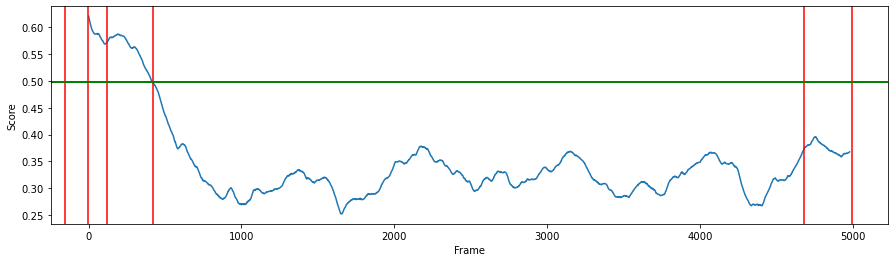

Video: 50


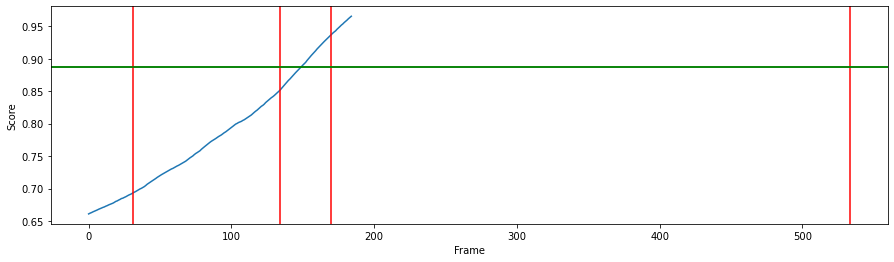

Video: 51


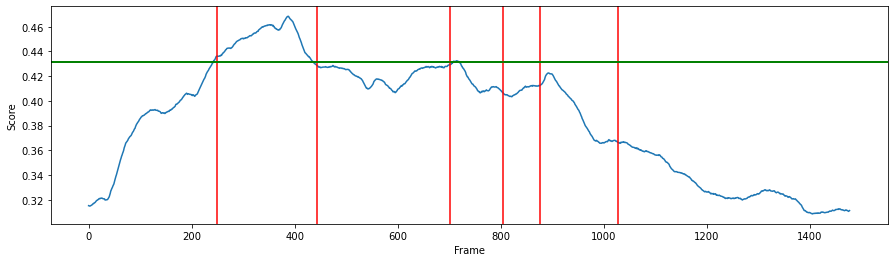

Video: 52


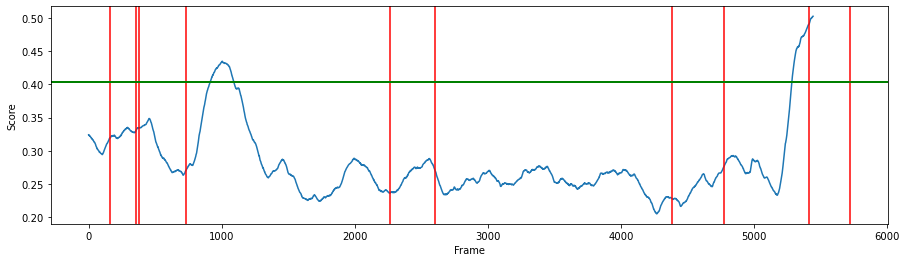

Video: 53


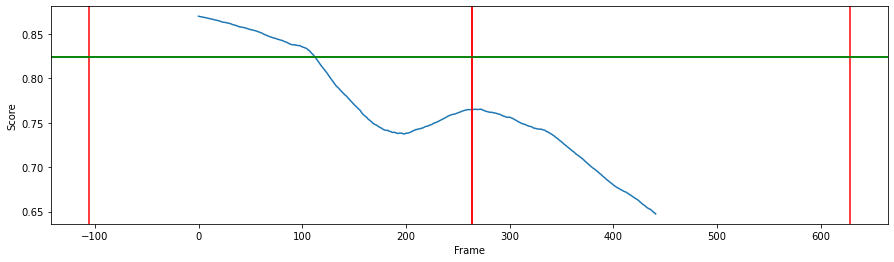

TP: 32 FP: 92 FN: 130
Done Subject 10
Subject : 11
Dataset Labels Counter({0: 268683, 1: 148527})
After Downsampling Dataset Labels Counter({1: 148527, 0: 134341})
------Initializing SOFTNet-------
Epoch 1/10
23573/23572 [==============================] - 72s 3ms/step - loss: 0.2030 - mean_absolute_error: 0.4104 - val_loss: 0.2078 - val_mean_absolute_error: 0.4034
Epoch 2/10
23573/23572 [==============================] - 70s 3ms/step - loss: 0.1867 - mean_absolute_error: 0.3834 - val_loss: 0.2103 - val_mean_absolute_error: 0.3947
Epoch 3/10
23573/23572 [==============================] - 69s 3ms/step - loss: 0.1817 - mean_absolute_error: 0.3748 - val_loss: 0.2121 - val_mean_absolute_error: 0.3914
Epoch 4/10
23573/23572 [==============================] - 69s 3ms/step - loss: 0.1778 - mean_absolute_error: 0.3684 - val_loss: 0.2147 - val_mean_absolute_error: 0.3896
Epoch 5/10
23573/23572 [==============================] - 72s 3ms/step - loss: 0.1744 - mean_absolute_error: 0.3627 - val_loss

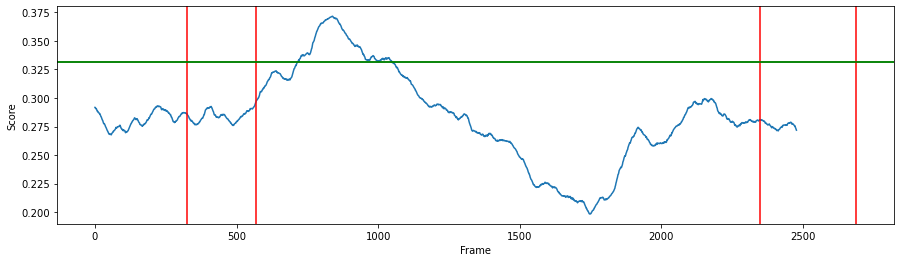

Video: 55


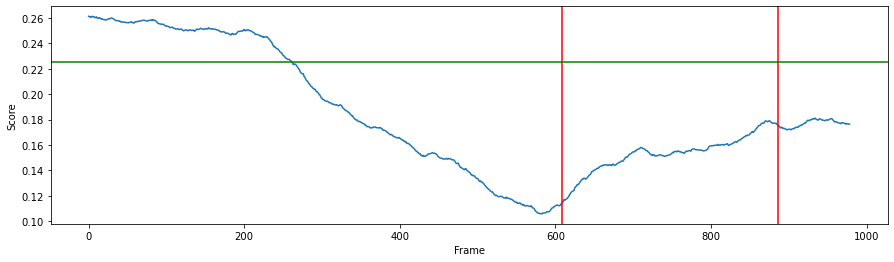

Video: 56


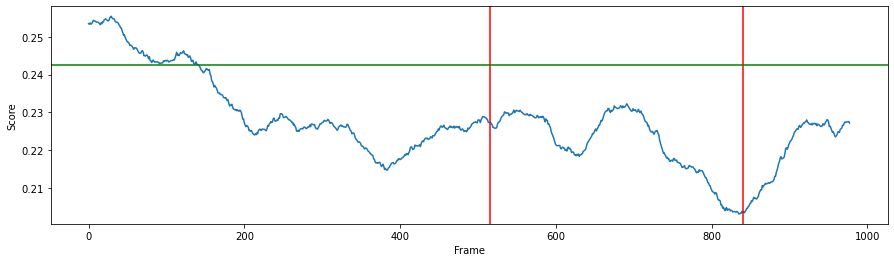

Video: 57


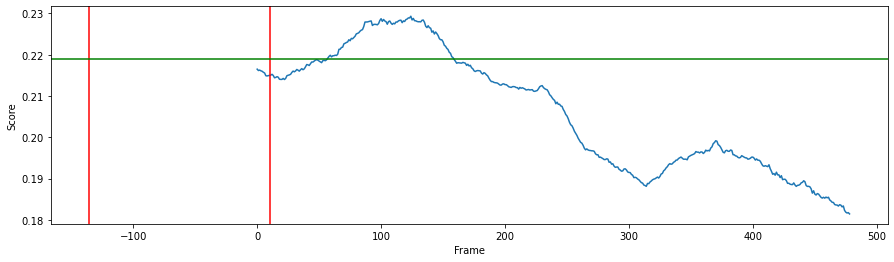

Video: 58


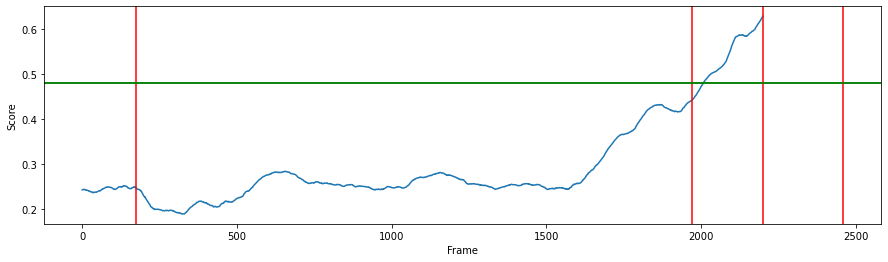

Video: 59


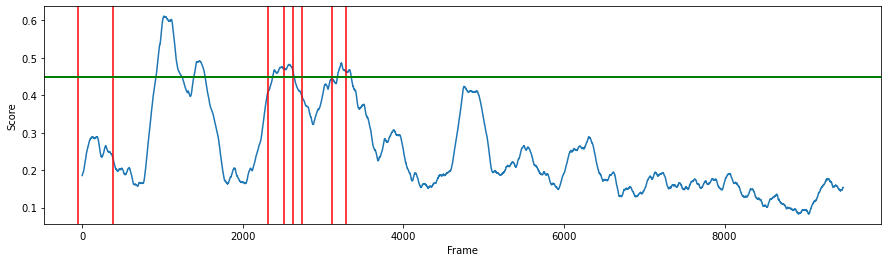

TP: 33 FP: 104 FN: 140
Done Subject 11
Subject : 12
Dataset Labels Counter({0: 275770, 1: 151662})
After Downsampling Dataset Labels Counter({1: 151662, 0: 137885})
------Initializing SOFTNet-------
Epoch 1/10
24129/24128 [==============================] - 69s 3ms/step - loss: 0.2045 - mean_absolute_error: 0.4128 - val_loss: 0.1959 - val_mean_absolute_error: 0.4170
Epoch 2/10
24129/24128 [==============================] - 69s 3ms/step - loss: 0.1893 - mean_absolute_error: 0.3877 - val_loss: 0.1939 - val_mean_absolute_error: 0.4102
Epoch 3/10
24129/24128 [==============================] - 69s 3ms/step - loss: 0.1845 - mean_absolute_error: 0.3796 - val_loss: 0.1946 - val_mean_absolute_error: 0.4085
Epoch 4/10
24129/24128 [==============================] - 69s 3ms/step - loss: 0.1807 - mean_absolute_error: 0.3734 - val_loss: 0.1958 - val_mean_absolute_error: 0.4076
Epoch 5/10
24129/24128 [==============================] - 69s 3ms/step - loss: 0.1773 - mean_absolute_error: 0.3678 - val_los

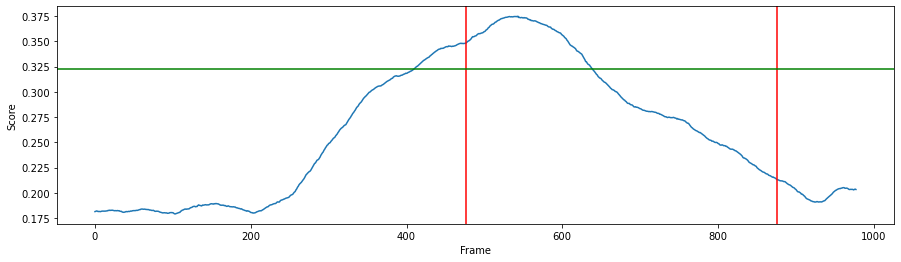

Video: 61


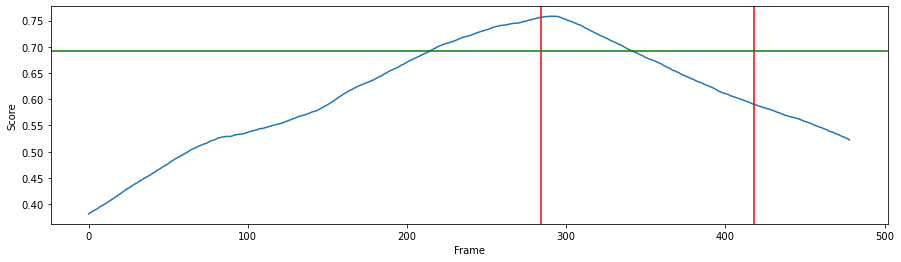

Video: 62


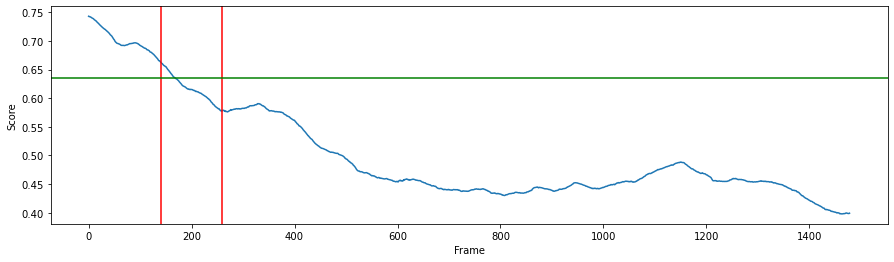

Video: 63


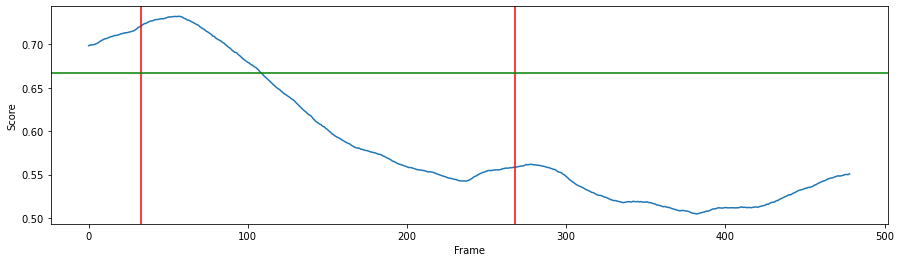

Video: 64


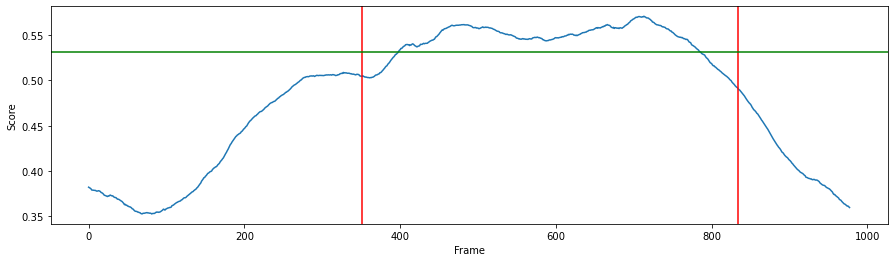

Video: 65


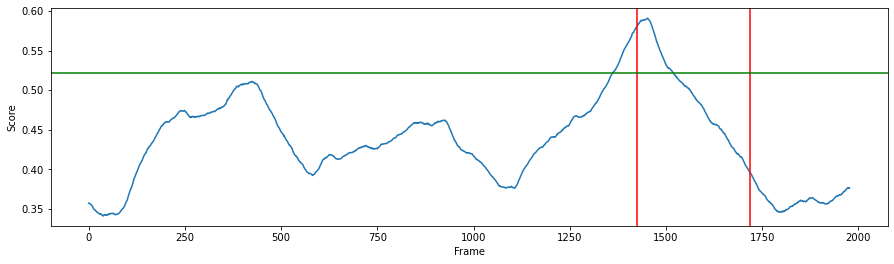

TP: 35 FP: 109 FN: 144
Done Subject 12
Subject : 13
Dataset Labels Counter({0: 266094, 1: 147289})
After Downsampling Dataset Labels Counter({1: 147289, 0: 133047})
------Initializing SOFTNet-------
Epoch 1/10
23362/23361 [==============================] - 69s 3ms/step - loss: 0.2056 - mean_absolute_error: 0.4152 - val_loss: 0.2090 - val_mean_absolute_error: 0.4067
Epoch 2/10
23362/23361 [==============================] - 69s 3ms/step - loss: 0.1900 - mean_absolute_error: 0.3899 - val_loss: 0.2177 - val_mean_absolute_error: 0.4111
Epoch 3/10
23362/23361 [==============================] - 69s 3ms/step - loss: 0.1850 - mean_absolute_error: 0.3815 - val_loss: 0.2246 - val_mean_absolute_error: 0.4164
Epoch 4/10
23362/23361 [==============================] - 68s 3ms/step - loss: 0.1812 - mean_absolute_error: 0.3752 - val_loss: 0.2295 - val_mean_absolute_error: 0.4206
Epoch 5/10
23362/23361 [==============================] - 68s 3ms/step - loss: 0.1779 - mean_absolute_error: 0.3697 - val_los

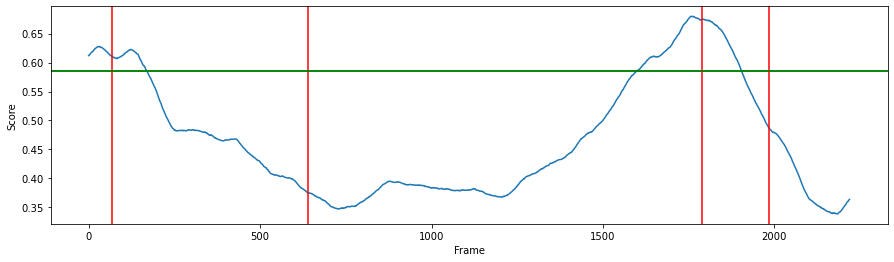

Video: 67


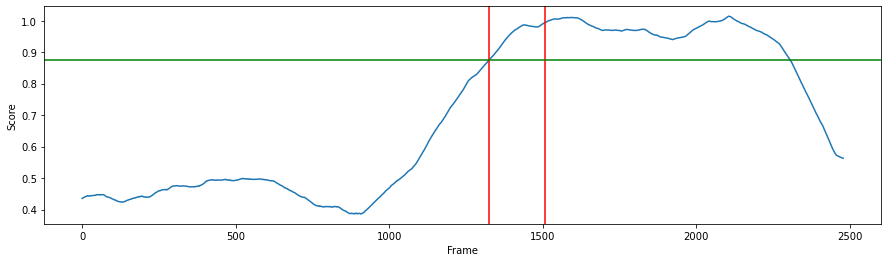

Video: 68


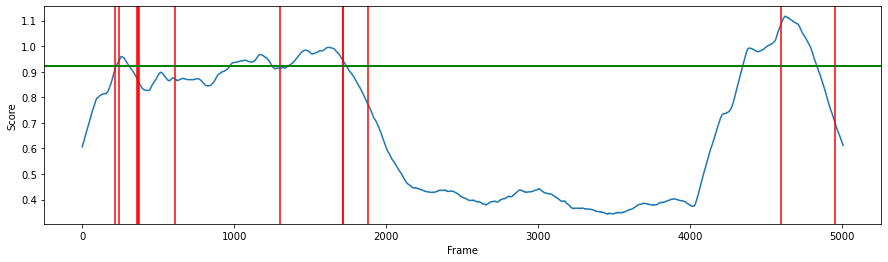

Video: 69


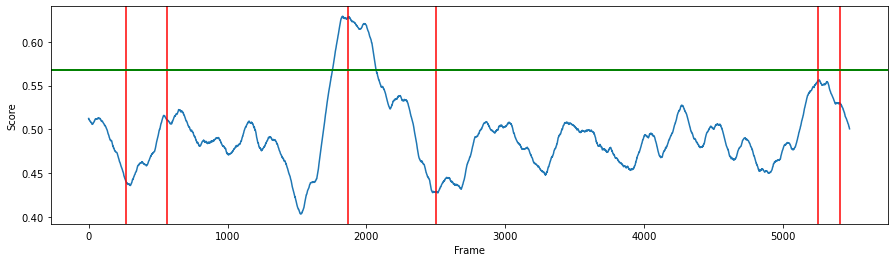

Video: 70


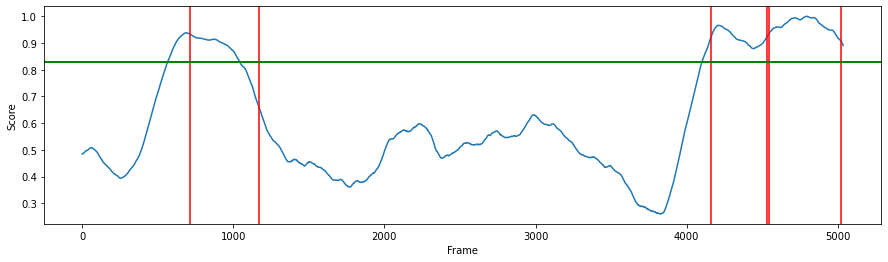

Video: 71


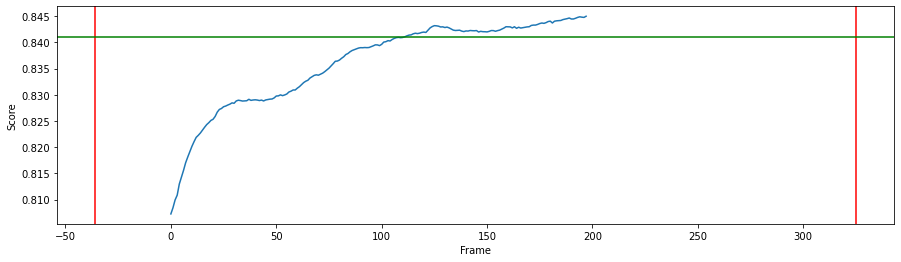

TP: 39 FP: 123 FN: 156
Done Subject 13
Subject : 14
Dataset Labels Counter({0: 271601, 1: 150159})
After Downsampling Dataset Labels Counter({1: 150159, 0: 135800})
------Initializing SOFTNet-------
Epoch 1/10
23830/23829 [==============================] - 69s 3ms/step - loss: 0.2047 - mean_absolute_error: 0.4129 - val_loss: 0.2021 - val_mean_absolute_error: 0.4331
Epoch 2/10
23830/23829 [==============================] - 70s 3ms/step - loss: 0.1892 - mean_absolute_error: 0.3878 - val_loss: 0.2027 - val_mean_absolute_error: 0.4327
Epoch 3/10
23830/23829 [==============================] - 70s 3ms/step - loss: 0.1843 - mean_absolute_error: 0.3794 - val_loss: 0.2046 - val_mean_absolute_error: 0.4340
Epoch 4/10
23830/23829 [==============================] - 74s 3ms/step - loss: 0.1806 - mean_absolute_error: 0.3733 - val_loss: 0.2061 - val_mean_absolute_error: 0.4347
Epoch 5/10
23830/23829 [==============================] - 74s 3ms/step - loss: 0.1772 - mean_absolute_error: 0.3677 - val_los

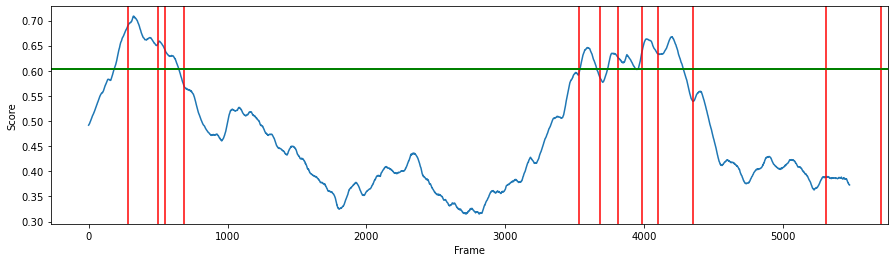

Video: 73


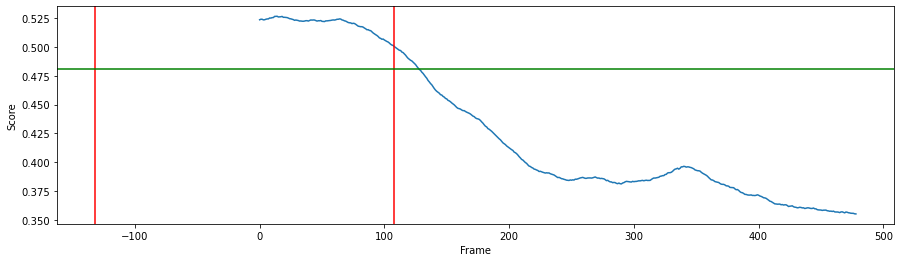

Video: 74


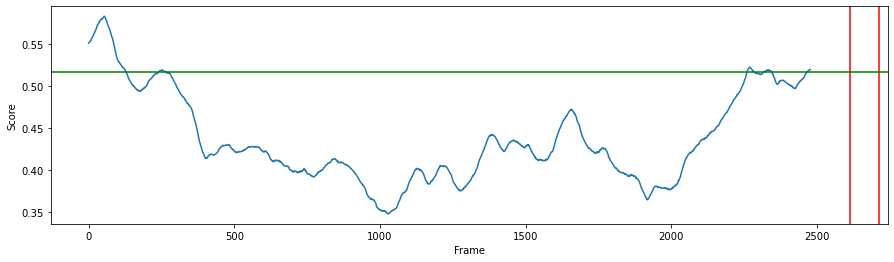

Video: 75


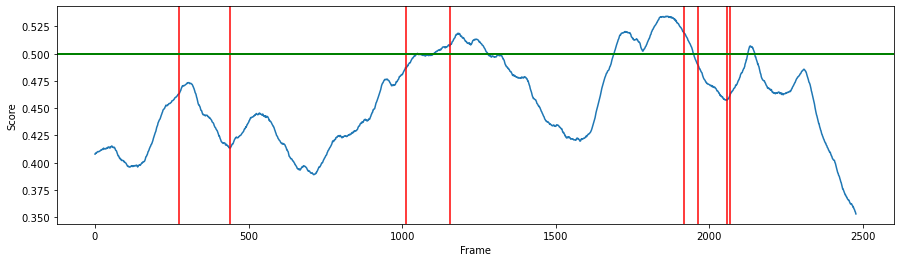

Video: 76


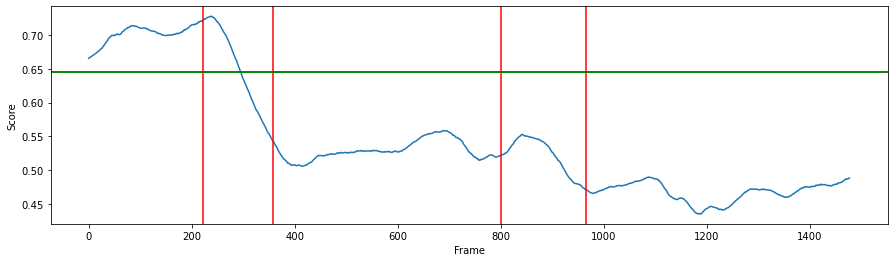

TP: 42 FP: 136 FN: 167
Done Subject 14
Subject : 15
Dataset Labels Counter({0: 262880, 1: 141987})
After Downsampling Dataset Labels Counter({1: 141987, 0: 131440})
------Initializing SOFTNet-------
Epoch 1/10
22786/22785 [==============================] - 72s 3ms/step - loss: 0.2070 - mean_absolute_error: 0.4178 - val_loss: 0.2064 - val_mean_absolute_error: 0.4000
Epoch 2/10
22786/22785 [==============================] - 72s 3ms/step - loss: 0.1910 - mean_absolute_error: 0.3912 - val_loss: 0.2029 - val_mean_absolute_error: 0.3907
Epoch 3/10
22786/22785 [==============================] - 71s 3ms/step - loss: 0.1861 - mean_absolute_error: 0.3829 - val_loss: 0.2001 - val_mean_absolute_error: 0.3841
Epoch 4/10
22786/22785 [==============================] - 71s 3ms/step - loss: 0.1824 - mean_absolute_error: 0.3769 - val_loss: 0.1979 - val_mean_absolute_error: 0.3793
Epoch 5/10
22786/22785 [==============================] - 71s 3ms/step - loss: 0.1792 - mean_absolute_error: 0.3716 - val_los

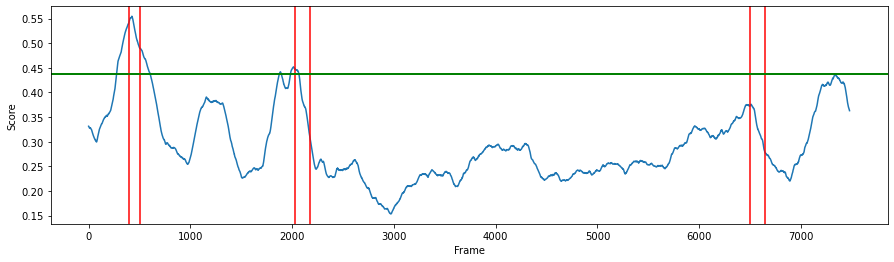

Video: 78


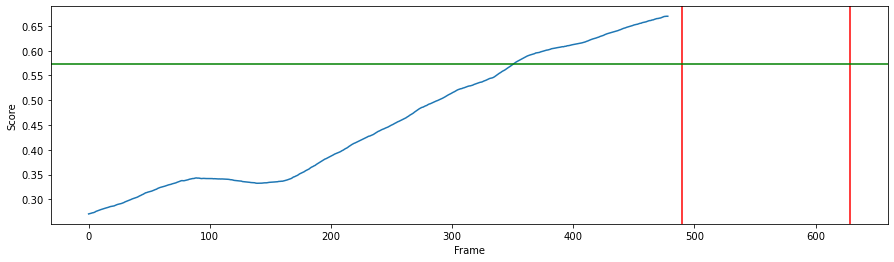

Video: 79


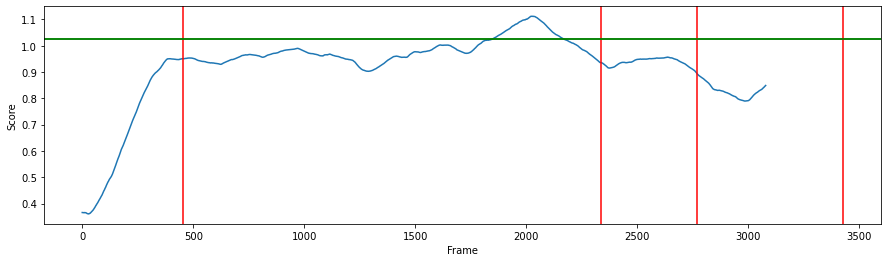

Video: 80


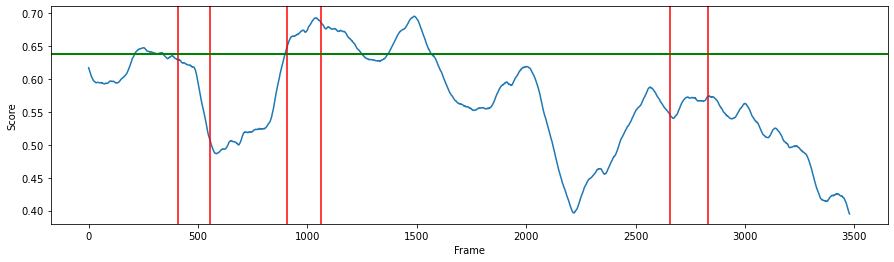

Video: 81


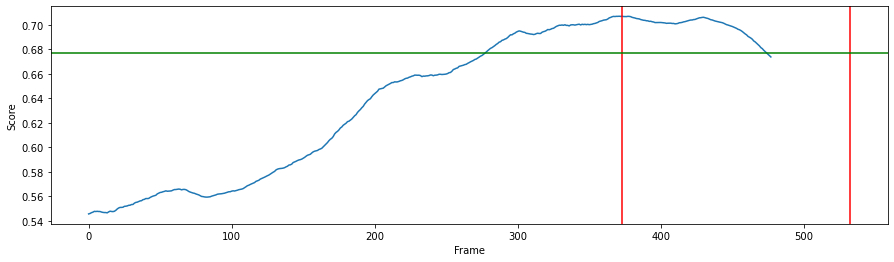

Video: 82


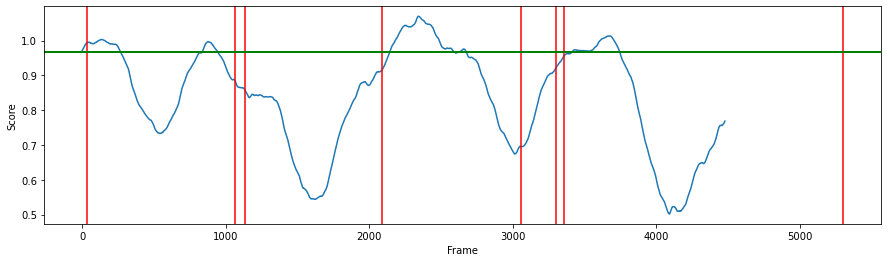

Video: 83


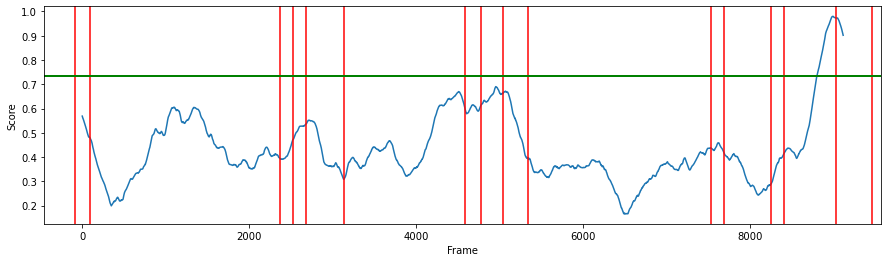

TP: 42 FP: 151 FN: 189
Done Subject 15
Subject : 16
Dataset Labels Counter({0: 279432, 1: 153214})
After Downsampling Dataset Labels Counter({1: 153214, 0: 139716})
------Initializing SOFTNet-------
Epoch 1/10
24411/24410 [==============================] - 68s 3ms/step - loss: 0.2046 - mean_absolute_error: 0.4131 - val_loss: 0.1886 - val_mean_absolute_error: 0.4100
Epoch 2/10
24411/24410 [==============================] - 68s 3ms/step - loss: 0.1892 - mean_absolute_error: 0.3877 - val_loss: 0.1861 - val_mean_absolute_error: 0.3996
Epoch 3/10
24411/24410 [==============================] - 69s 3ms/step - loss: 0.1845 - mean_absolute_error: 0.3796 - val_loss: 0.1862 - val_mean_absolute_error: 0.3963
Epoch 4/10
24411/24410 [==============================] - 69s 3ms/step - loss: 0.1808 - mean_absolute_error: 0.3735 - val_loss: 0.1858 - val_mean_absolute_error: 0.3943
Epoch 5/10
24411/24410 [==============================] - 68s 3ms/step - loss: 0.1775 - mean_absolute_error: 0.3681 - val_los

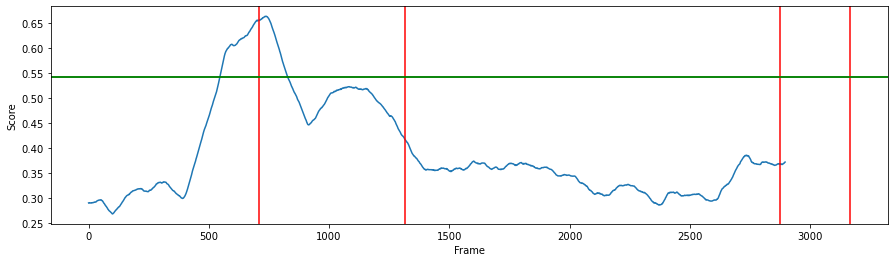

TP: 42 FP: 152 FN: 191
Done Subject 16
Subject : 17
Dataset Labels Counter({0: 274290, 1: 151889})
After Downsampling Dataset Labels Counter({1: 151889, 0: 137145})
------Initializing SOFTNet-------
Epoch 1/10
24087/24086 [==============================] - 69s 3ms/step - loss: 0.2040 - mean_absolute_error: 0.4121 - val_loss: 0.1963 - val_mean_absolute_error: 0.4034
Epoch 2/10
24087/24086 [==============================] - 69s 3ms/step - loss: 0.1884 - mean_absolute_error: 0.3862 - val_loss: 0.1978 - val_mean_absolute_error: 0.4004
Epoch 3/10
24087/24086 [==============================] - 69s 3ms/step - loss: 0.1835 - mean_absolute_error: 0.3780 - val_loss: 0.1971 - val_mean_absolute_error: 0.3979
Epoch 4/10
24087/24086 [==============================] - 69s 3ms/step - loss: 0.1798 - mean_absolute_error: 0.3718 - val_loss: 0.1963 - val_mean_absolute_error: 0.3950
Epoch 5/10
24087/24086 [==============================] - 69s 3ms/step - loss: 0.1764 - mean_absolute_error: 0.3663 - val_los

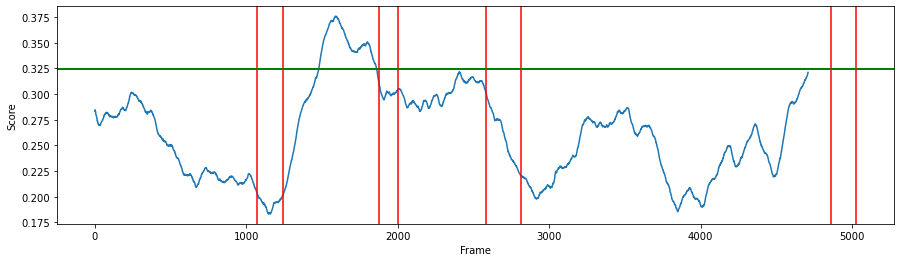

Video: 86


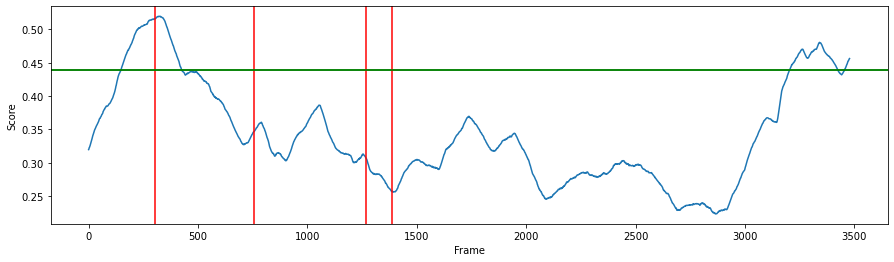

Video: 87


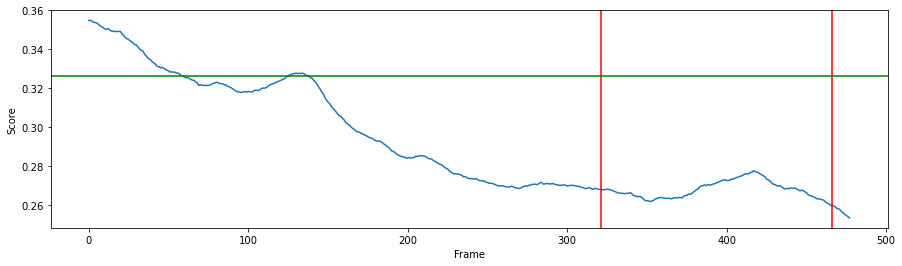

TP: 42 FP: 157 FN: 198
Done Subject 17
Subject : 18
Dataset Labels Counter({0: 281308, 1: 153756})
After Downsampling Dataset Labels Counter({1: 153756, 0: 140654})
------Initializing SOFTNet-------
Epoch 1/10
24535/24534 [==============================] - 68s 3ms/step - loss: 0.2050 - mean_absolute_error: 0.4139 - val_loss: 0.1285 - val_mean_absolute_error: 0.3040
Epoch 2/10
24535/24534 [==============================] - 69s 3ms/step - loss: 0.1896 - mean_absolute_error: 0.3884 - val_loss: 0.1285 - val_mean_absolute_error: 0.3015
Epoch 3/10
24535/24534 [==============================] - 69s 3ms/step - loss: 0.1848 - mean_absolute_error: 0.3802 - val_loss: 0.1317 - val_mean_absolute_error: 0.3026
Epoch 4/10
24535/24534 [==============================] - 69s 3ms/step - loss: 0.1811 - mean_absolute_error: 0.3741 - val_loss: 0.1348 - val_mean_absolute_error: 0.3044
Epoch 5/10
24535/24534 [==============================] - 69s 3ms/step - loss: 0.1777 - mean_absolute_error: 0.3686 - val_los

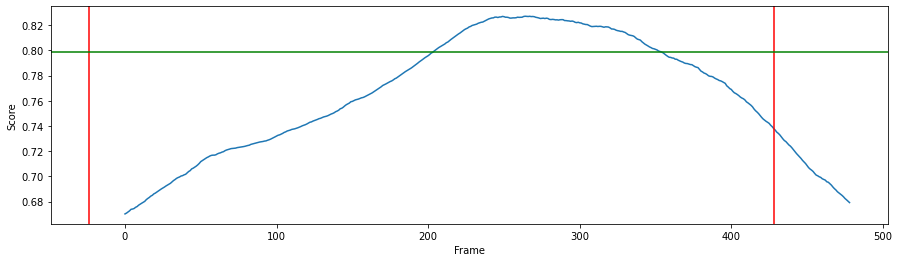

TP: 43 FP: 157 FN: 198
Done Subject 18
Subject : 19
Dataset Labels Counter({0: 278188, 1: 152522})
After Downsampling Dataset Labels Counter({1: 152522, 0: 139094})
------Initializing SOFTNet-------
Epoch 1/10
24302/24301 [==============================] - 69s 3ms/step - loss: 0.2039 - mean_absolute_error: 0.4118 - val_loss: 0.2333 - val_mean_absolute_error: 0.4513
Epoch 2/10
24302/24301 [==============================] - 69s 3ms/step - loss: 0.1885 - mean_absolute_error: 0.3862 - val_loss: 0.2296 - val_mean_absolute_error: 0.4475
Epoch 3/10
24302/24301 [==============================] - 69s 3ms/step - loss: 0.1837 - mean_absolute_error: 0.3781 - val_loss: 0.2271 - val_mean_absolute_error: 0.4430
Epoch 4/10
24302/24301 [==============================] - 69s 3ms/step - loss: 0.1800 - mean_absolute_error: 0.3720 - val_loss: 0.2246 - val_mean_absolute_error: 0.4375
Epoch 5/10
24302/24301 [==============================] - 69s 3ms/step - loss: 0.1767 - mean_absolute_error: 0.3666 - val_los

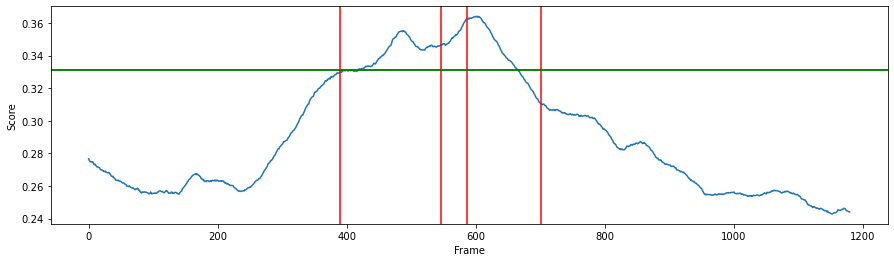

Video: 90


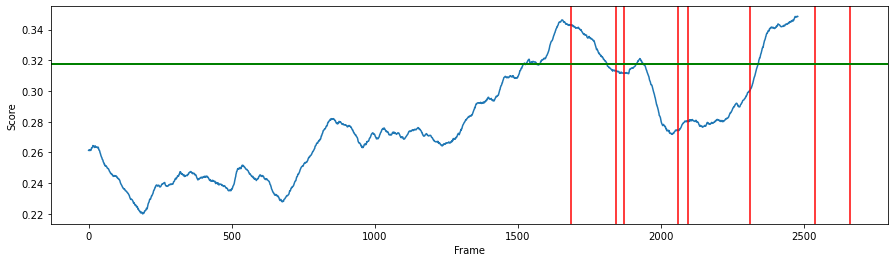

Video: 91


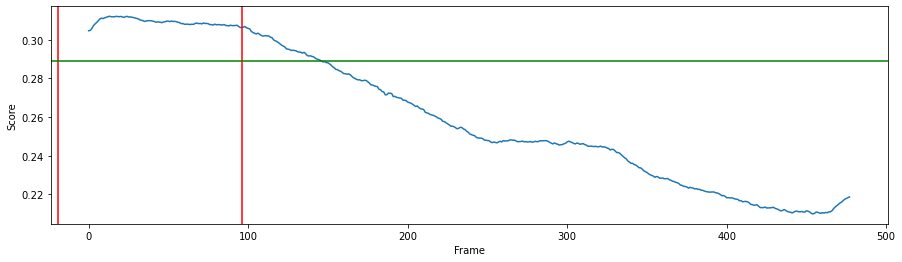

TP: 44 FP: 162 FN: 204
Done Subject 19
Subject : 20
Dataset Labels Counter({0: 278472, 1: 152266})
After Downsampling Dataset Labels Counter({1: 152266, 0: 139236})
------Initializing SOFTNet-------
Epoch 1/10
24292/24291 [==============================] - 69s 3ms/step - loss: 0.2049 - mean_absolute_error: 0.4138 - val_loss: 0.1935 - val_mean_absolute_error: 0.4078
Epoch 2/10
24292/24291 [==============================] - 69s 3ms/step - loss: 0.1894 - mean_absolute_error: 0.3881 - val_loss: 0.1983 - val_mean_absolute_error: 0.4123
Epoch 3/10
24292/24291 [==============================] - 70s 3ms/step - loss: 0.1845 - mean_absolute_error: 0.3798 - val_loss: 0.1997 - val_mean_absolute_error: 0.4140
Epoch 4/10
24292/24291 [==============================] - 69s 3ms/step - loss: 0.1808 - mean_absolute_error: 0.3737 - val_loss: 0.1992 - val_mean_absolute_error: 0.4131
Epoch 5/10
24292/24291 [==============================] - 69s 3ms/step - loss: 0.1775 - mean_absolute_error: 0.3682 - val_los

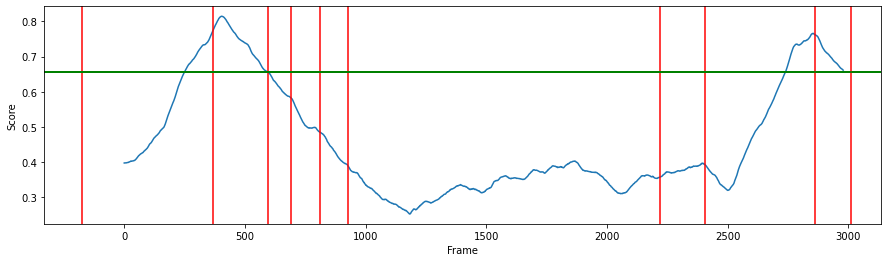

Video: 93


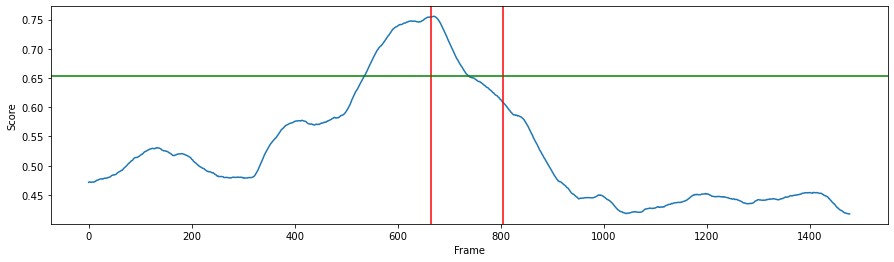

TP: 45 FP: 165 FN: 209
Done Subject 20
Subject : 21
Dataset Labels Counter({0: 270507, 1: 152011})
After Downsampling Dataset Labels Counter({1: 152011, 0: 135253})
------Initializing SOFTNet-------
Epoch 1/10
23939/23938 [==============================] - 70s 3ms/step - loss: 0.2057 - mean_absolute_error: 0.4151 - val_loss: 0.1439 - val_mean_absolute_error: 0.3377
Epoch 2/10
23939/23938 [==============================] - ETA: 40s - loss: 0.1459 - mean_absolute_error: 0.333 - 69s 3ms/step - loss: 0.1900 - mean_absolute_error: 0.3895 - val_loss: 0.1439 - val_mean_absolute_error: 0.3304
Epoch 3/10
23939/23938 [==============================] - 69s 3ms/step - loss: 0.1851 - mean_absolute_error: 0.3811 - val_loss: 0.1461 - val_mean_absolute_error: 0.3327
Epoch 4/10
23939/23938 [==============================] - 69s 3ms/step - loss: 0.1813 - mean_absolute_error: 0.3748 - val_loss: 0.1481 - val_mean_absolute_error: 0.3355
Epoch 5/10
23939/23938 [==============================] - 69s 3ms/step

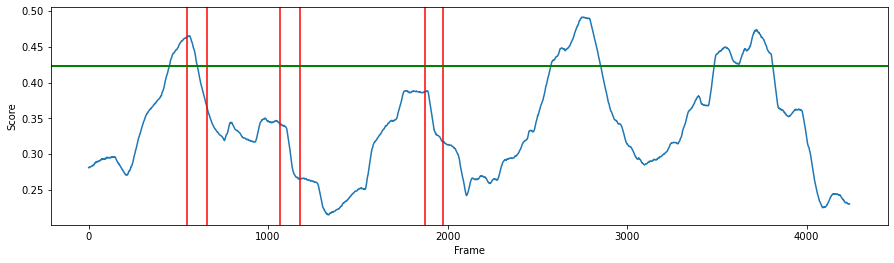

Video: 95


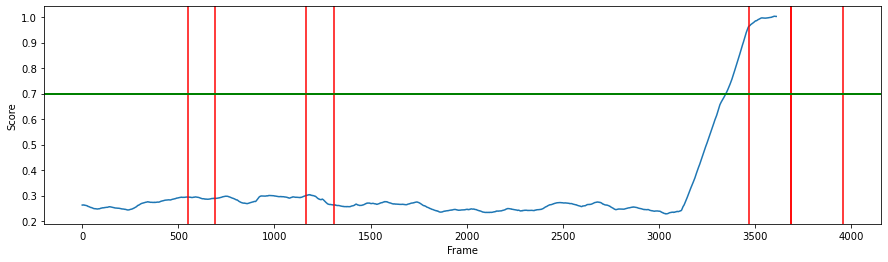

Video: 96


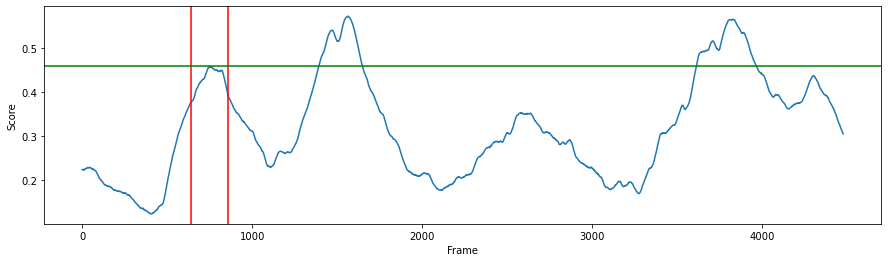

TP: 46 FP: 172 FN: 216
Done Subject 21
Subject : 22
Dataset Labels Counter({0: 280410, 1: 153654})
After Downsampling Dataset Labels Counter({1: 153654, 0: 140205})
------Initializing SOFTNet-------
Epoch 1/10
24489/24488 [==============================] - 69s 3ms/step - loss: 0.2047 - mean_absolute_error: 0.4134 - val_loss: 0.2140 - val_mean_absolute_error: 0.4052
Epoch 2/10
24489/24488 [==============================] - 69s 3ms/step - loss: 0.1893 - mean_absolute_error: 0.3879 - val_loss: 0.2162 - val_mean_absolute_error: 0.4035
Epoch 3/10
24489/24488 [==============================] - 70s 3ms/step - loss: 0.1845 - mean_absolute_error: 0.3796 - val_loss: 0.2189 - val_mean_absolute_error: 0.4033
Epoch 4/10
24489/24488 [==============================] - 69s 3ms/step - loss: 0.1808 - mean_absolute_error: 0.3735 - val_loss: 0.2207 - val_mean_absolute_error: 0.4024
Epoch 5/10
24489/24488 [==============================] - 69s 3ms/step - loss: 0.1774 - mean_absolute_error: 0.3680 - val_los

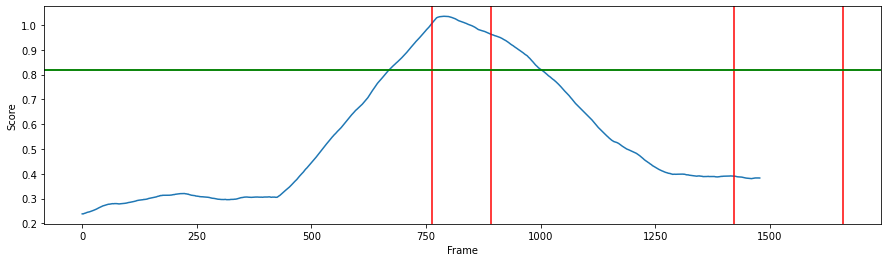

TP: 46 FP: 173 FN: 218
Done Subject 22
Subject : 23
Dataset Labels Counter({0: 274038, 1: 151874})
After Downsampling Dataset Labels Counter({1: 151874, 0: 137019})
------Initializing SOFTNet-------
Epoch 1/10
24075/24074 [==============================] - ETA: 40s - loss: 0.1810 - mean_absolute_error: 0.376 - 69s 3ms/step - loss: 0.2042 - mean_absolute_error: 0.4125 - val_loss: 0.1809 - val_mean_absolute_error: 0.3767
Epoch 2/10
24075/24074 [==============================] - 69s 3ms/step - loss: 0.1888 - mean_absolute_error: 0.3869 - val_loss: 0.1793 - val_mean_absolute_error: 0.3673
Epoch 3/10
24075/24074 [==============================] - 69s 3ms/step - loss: 0.1839 - mean_absolute_error: 0.3787 - val_loss: 0.1786 - val_mean_absolute_error: 0.3626
Epoch 4/10
24075/24074 [==============================] - 70s 3ms/step - loss: 0.1802 - mean_absolute_error: 0.3725 - val_loss: 0.1783 - val_mean_absolute_error: 0.3591
Epoch 5/10
24075/24074 [==============================] - 70s 3ms/step

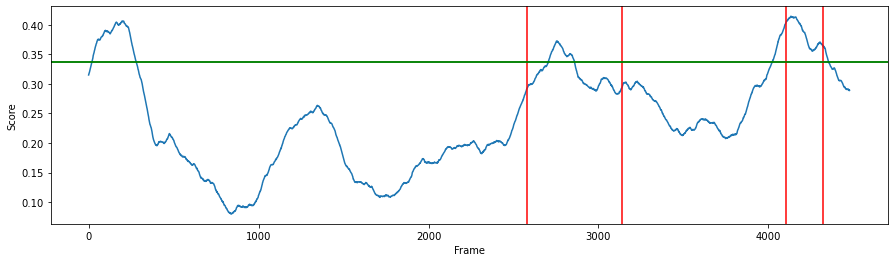

Video: 99


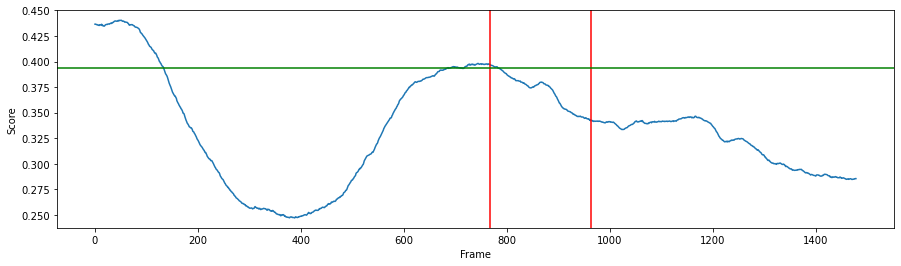

Video: 100


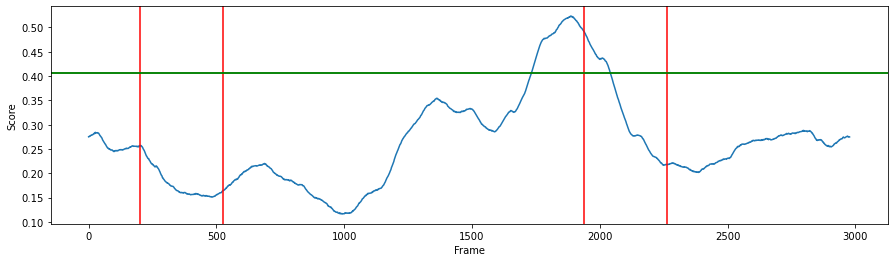

TP: 48 FP: 178 FN: 221
Done Subject 23
Subject : 24
Dataset Labels Counter({0: 271362, 1: 149763})
After Downsampling Dataset Labels Counter({1: 149763, 0: 135681})
------Initializing SOFTNet-------
Epoch 1/10
23787/23787 [==============================] - 69s 3ms/step - loss: 0.2060 - mean_absolute_error: 0.4156 - val_loss: 0.1609 - val_mean_absolute_error: 0.3731
Epoch 2/10
23787/23787 [==============================] - 68s 3ms/step - loss: 0.1906 - mean_absolute_error: 0.3906 - val_loss: 0.1574 - val_mean_absolute_error: 0.3646
Epoch 3/10
23787/23787 [==============================] - 69s 3ms/step - loss: 0.1857 - mean_absolute_error: 0.3822 - val_loss: 0.1571 - val_mean_absolute_error: 0.3627
Epoch 4/10
23787/23787 [==============================] - 69s 3ms/step - loss: 0.1820 - mean_absolute_error: 0.3760 - val_loss: 0.1576 - val_mean_absolute_error: 0.3625
Epoch 5/10
23787/23787 [==============================] - 69s 3ms/step - loss: 0.1787 - mean_absolute_error: 0.3704 - val_los

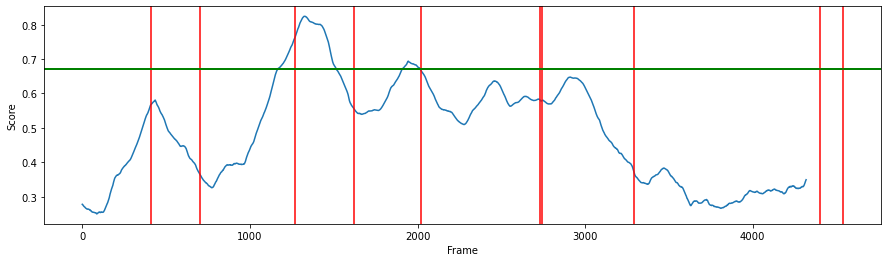

Video: 102


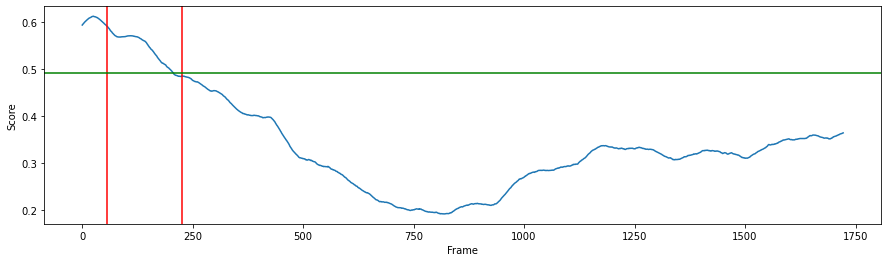

Video: 103


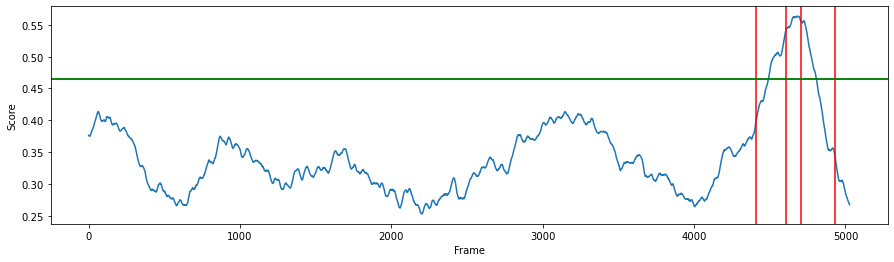

Video: 104


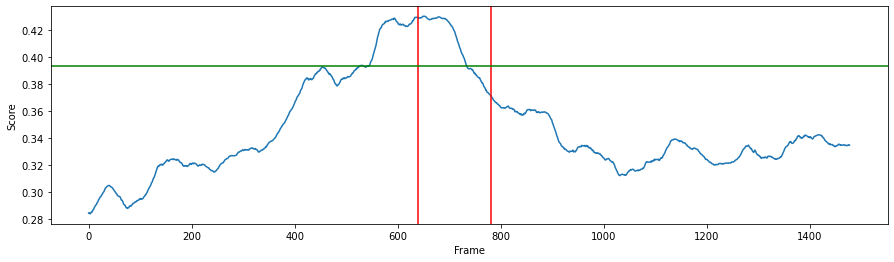

Video: 105


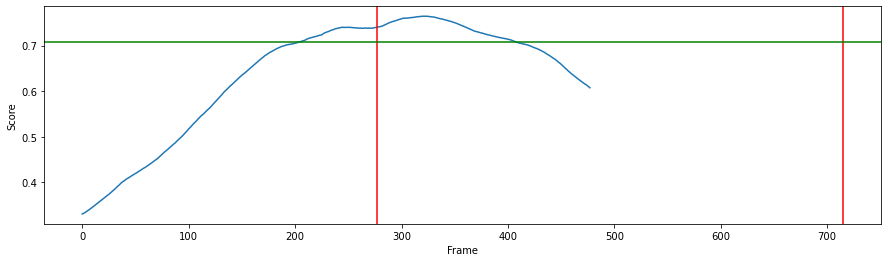

TP: 49 FP: 184 FN: 230
Done Subject 24
Subject : 25
Dataset Labels Counter({0: 270347, 1: 147477})
After Downsampling Dataset Labels Counter({1: 147477, 0: 135173})
------Initializing SOFTNet-------
Epoch 1/10
23555/23554 [==============================] - 69s 3ms/step - loss: 0.2058 - mean_absolute_error: 0.4152 - val_loss: 0.2204 - val_mean_absolute_error: 0.4270
Epoch 2/10
23555/23554 [==============================] - ETA: 37s - loss: 0.2314 - mean_absolute_error: 0.430 - 69s 3ms/step - loss: 0.1899 - mean_absolute_error: 0.3891 - val_loss: 0.2327 - val_mean_absolute_error: 0.4319
Epoch 3/10
23555/23554 [==============================] - 69s 3ms/step - loss: 0.1848 - mean_absolute_error: 0.3802 - val_loss: 0.2400 - val_mean_absolute_error: 0.4360
Epoch 4/10
23555/23554 [==============================] - 69s 3ms/step - loss: 0.1810 - mean_absolute_error: 0.3737 - val_loss: 0.2446 - val_mean_absolute_error: 0.4383
Epoch 5/10
23555/23554 [==============================] - 69s 3ms/step

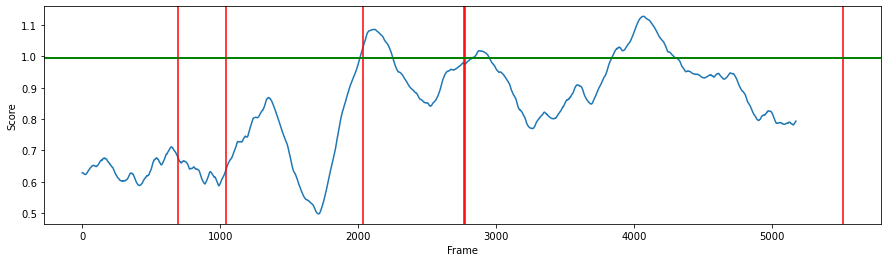

Video: 107


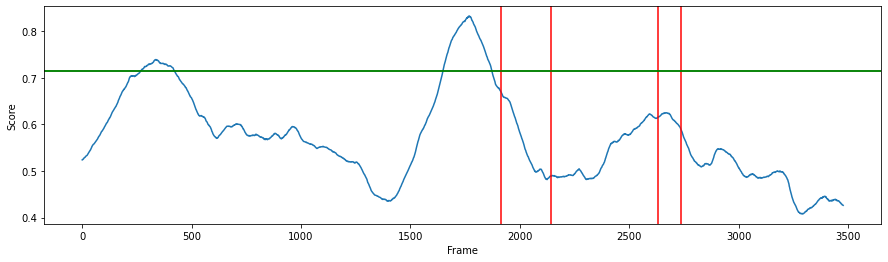

Video: 108


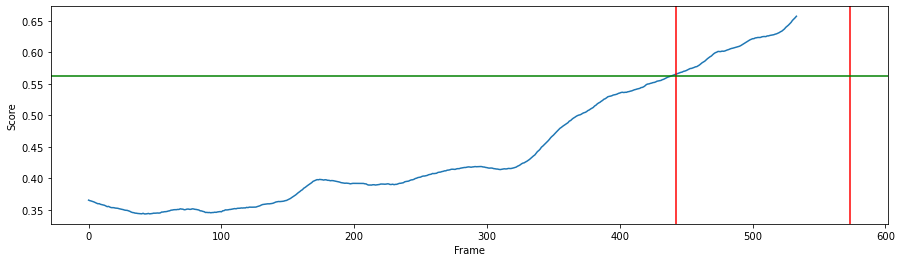

Video: 109


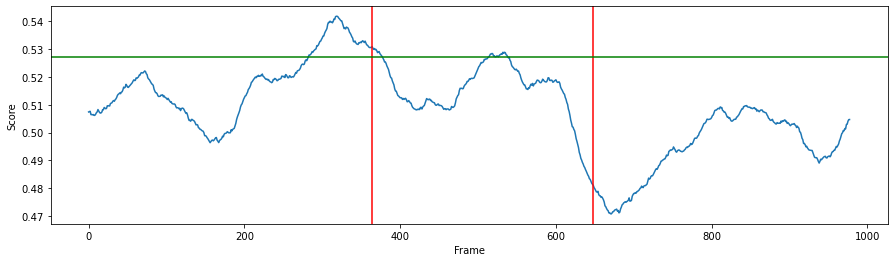

Video: 110


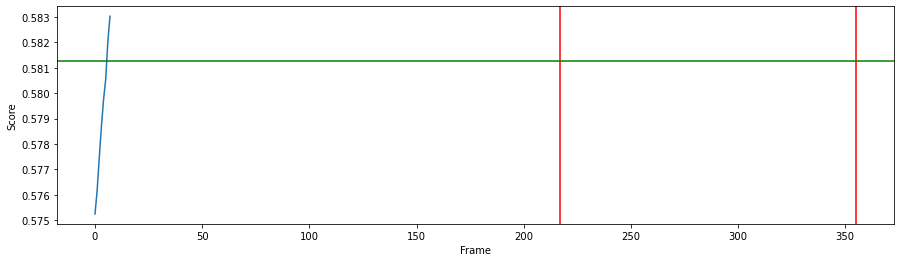

Video: 111


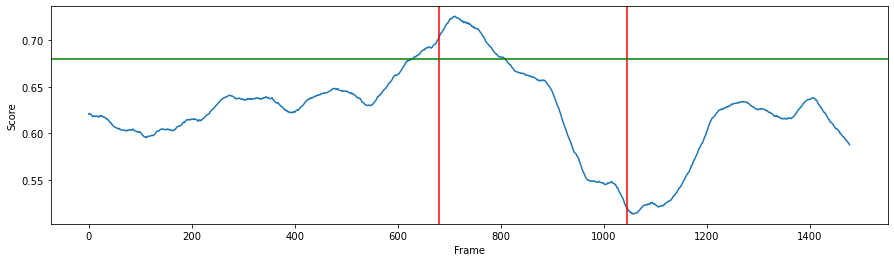

Video: 112


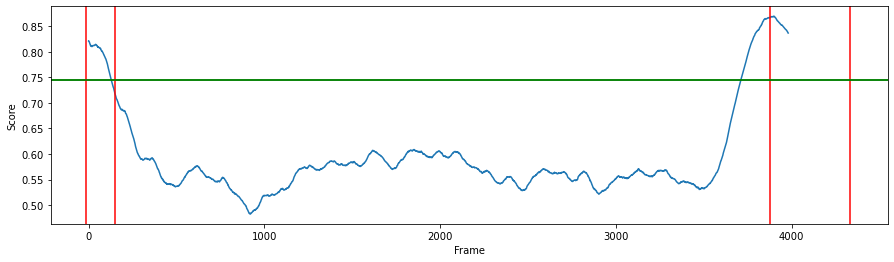

TP: 50 FP: 197 FN: 240
Done Subject 25
Subject : 26
Dataset Labels Counter({0: 275641, 1: 152597})
After Downsampling Dataset Labels Counter({1: 152597, 0: 137820})
------Initializing SOFTNet-------
Epoch 1/10
24202/24201 [==============================] - 69s 3ms/step - loss: 0.2056 - mean_absolute_error: 0.4149 - val_loss: 0.1406 - val_mean_absolute_error: 0.3448
Epoch 2/10
24202/24201 [==============================] - 69s 3ms/step - loss: 0.1903 - mean_absolute_error: 0.3899 - val_loss: 0.1408 - val_mean_absolute_error: 0.3404
Epoch 3/10
24202/24201 [==============================] - 69s 3ms/step - loss: 0.1856 - mean_absolute_error: 0.3817 - val_loss: 0.1410 - val_mean_absolute_error: 0.3382
Epoch 4/10
24202/24201 [==============================] - 69s 3ms/step - loss: 0.1820 - mean_absolute_error: 0.3757 - val_loss: 0.1400 - val_mean_absolute_error: 0.3351
Epoch 5/10
24202/24201 [==============================] - 69s 3ms/step - loss: 0.1787 - mean_absolute_error: 0.3703 - val_los

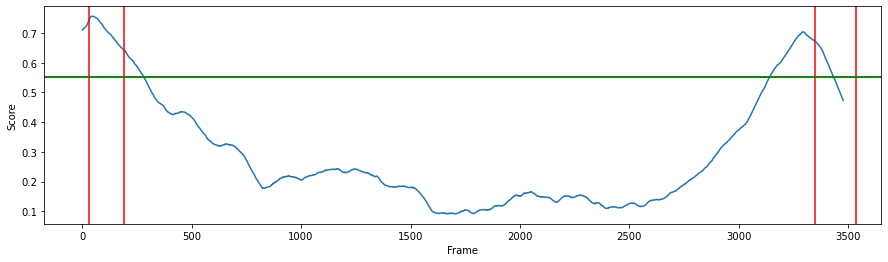

Video: 114


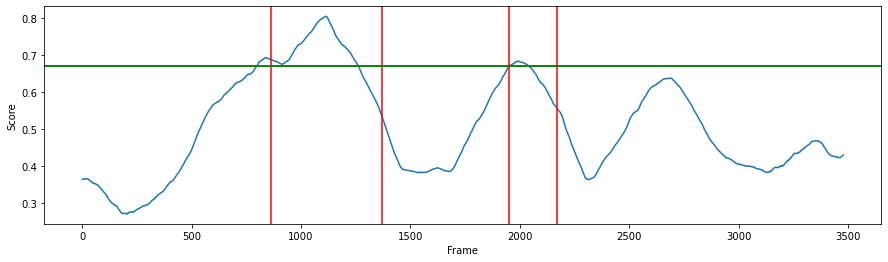

TP: 52 FP: 200 FN: 242
Done Subject 26
Subject : 27
Dataset Labels Counter({0: 265395, 1: 148672})
After Downsampling Dataset Labels Counter({1: 148672, 0: 132697})
------Initializing SOFTNet-------
Epoch 1/10
23448/23447 [==============================] - 70s 3ms/step - loss: 0.2041 - mean_absolute_error: 0.4120 - val_loss: 0.2270 - val_mean_absolute_error: 0.4513
Epoch 2/10
23448/23447 [==============================] - 69s 3ms/step - loss: 0.1887 - mean_absolute_error: 0.3867 - val_loss: 0.2188 - val_mean_absolute_error: 0.4394
Epoch 3/10
23448/23447 [==============================] - 69s 3ms/step - loss: 0.1838 - mean_absolute_error: 0.3787 - val_loss: 0.2162 - val_mean_absolute_error: 0.4339
Epoch 4/10
23448/23447 [==============================] - 69s 3ms/step - loss: 0.1801 - mean_absolute_error: 0.3726 - val_loss: 0.2170 - val_mean_absolute_error: 0.4320
Epoch 5/10
23448/23447 [==============================] - 69s 3ms/step - loss: 0.1768 - mean_absolute_error: 0.3671 - val_los

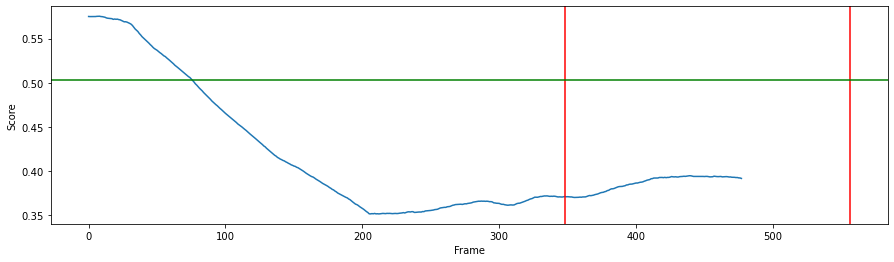

Video: 116


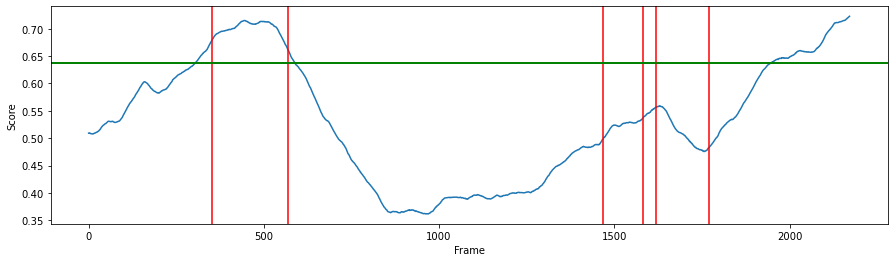

Video: 117


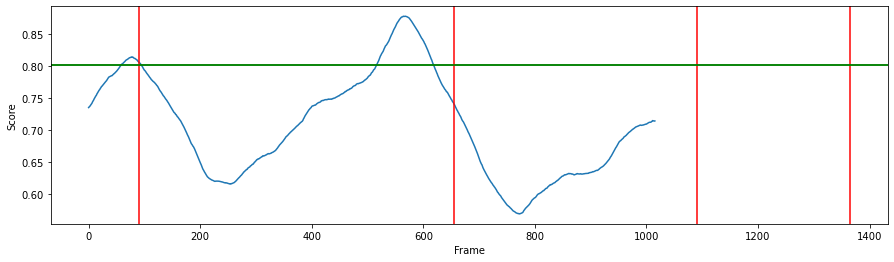

Video: 118


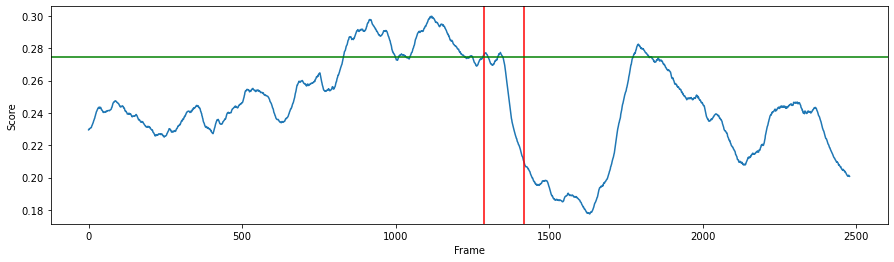

Video: 119


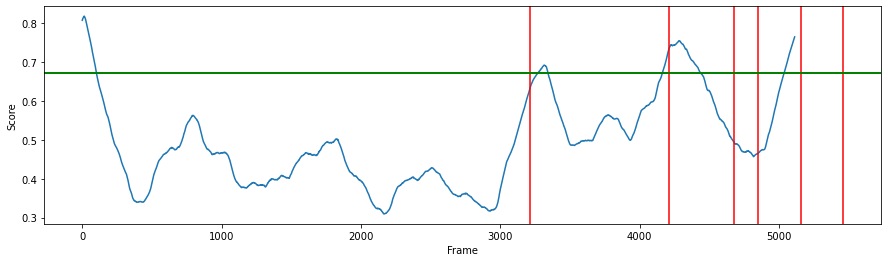

Video: 120


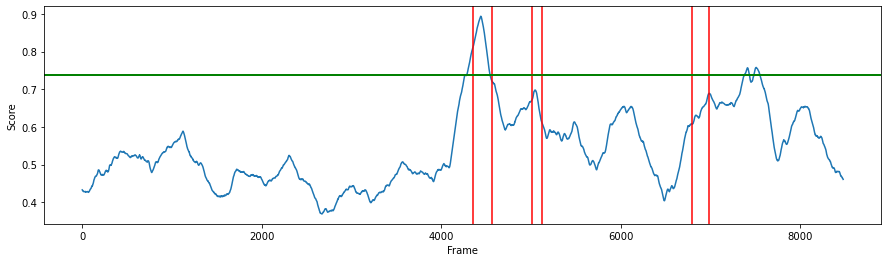

TP: 54 FP: 214 FN: 253
Done Subject 27
Subject : 28
Dataset Labels Counter({0: 275945, 1: 139124})
After Downsampling Dataset Labels Counter({1: 139124, 0: 137972})
------Initializing SOFTNet-------
Epoch 1/10
23092/23091 [==============================] - 68s 3ms/step - loss: 0.2095 - mean_absolute_error: 0.4223 - val_loss: 0.1661 - val_mean_absolute_error: 0.3303
Epoch 2/10
23092/23091 [==============================] - 68s 3ms/step - loss: 0.1936 - mean_absolute_error: 0.3959 - val_loss: 0.1635 - val_mean_absolute_error: 0.3260
Epoch 3/10
23092/23091 [==============================] - 68s 3ms/step - loss: 0.1886 - mean_absolute_error: 0.3873 - val_loss: 0.1629 - val_mean_absolute_error: 0.3268
Epoch 4/10
23092/23091 [==============================] - 68s 3ms/step - loss: 0.1848 - mean_absolute_error: 0.3812 - val_loss: 0.1622 - val_mean_absolute_error: 0.3272
Epoch 5/10
23092/23091 [==============================] - 68s 3ms/step - loss: 0.1815 - mean_absolute_error: 0.3757 - val_los

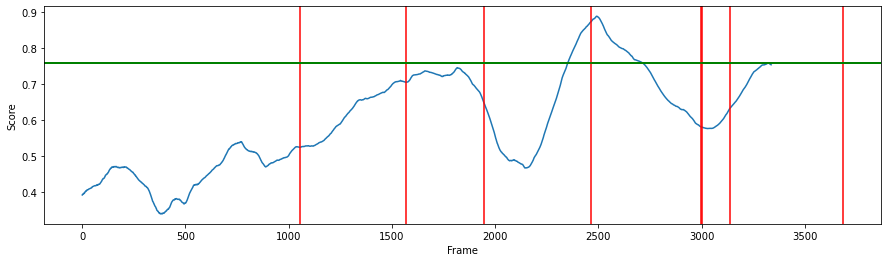

Video: 122


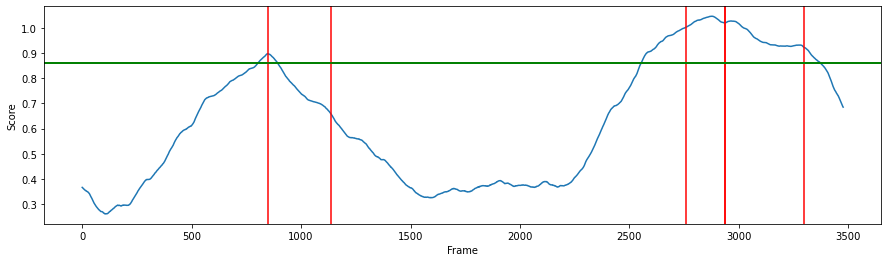

Video: 123


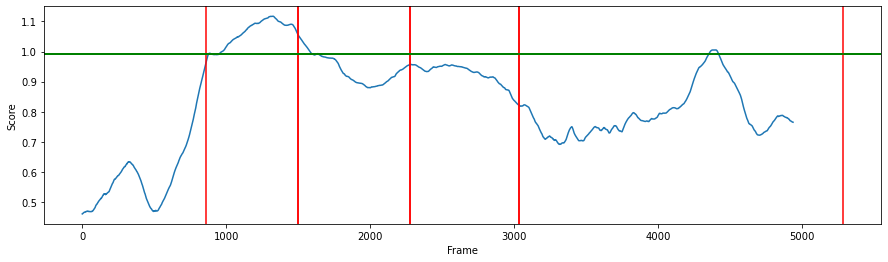

Video: 124


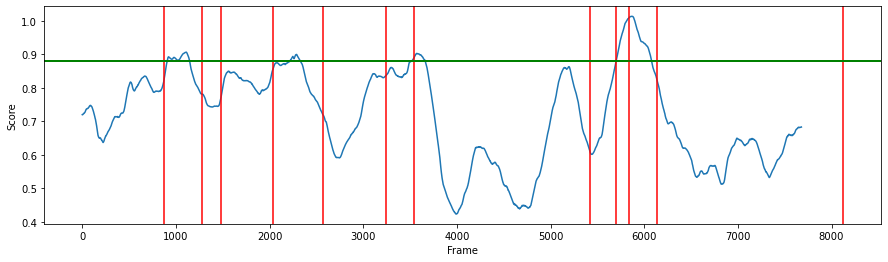

TP: 60 FP: 224 FN: 264
Done Subject 28
Subject : 29
Dataset Labels Counter({0: 269319, 1: 150874})
After Downsampling Dataset Labels Counter({1: 150874, 0: 134659})
------Initializing SOFTNet-------
Epoch 1/10
23795/23794 [==============================] - 69s 3ms/step - loss: 0.2054 - mean_absolute_error: 0.4146 - val_loss: 0.2081 - val_mean_absolute_error: 0.4390
Epoch 2/10
23795/23794 [==============================] - ETA: 38s - loss: 0.2033 - mean_absolute_error: 0.429 - 69s 3ms/step - loss: 0.1899 - mean_absolute_error: 0.3887 - val_loss: 0.2031 - val_mean_absolute_error: 0.4295
Epoch 3/10
23795/23794 [==============================] - 69s 3ms/step - loss: 0.1853 - mean_absolute_error: 0.3808 - val_loss: 0.1979 - val_mean_absolute_error: 0.4220
Epoch 4/10
23795/23794 [==============================] - 69s 3ms/step - loss: 0.1818 - mean_absolute_error: 0.3752 - val_loss: 0.1931 - val_mean_absolute_error: 0.4157
Epoch 5/10
23795/23794 [==============================] - 69s 3ms/step

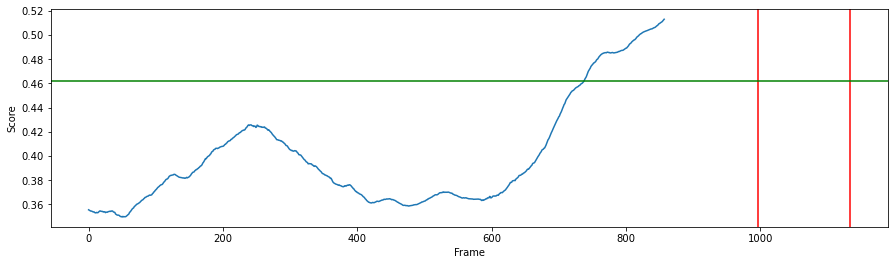

Video: 126


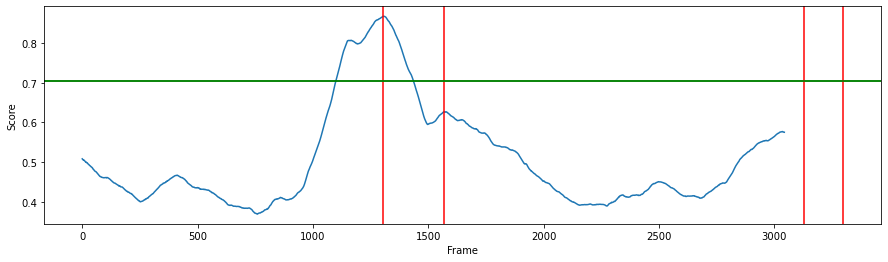

Video: 127


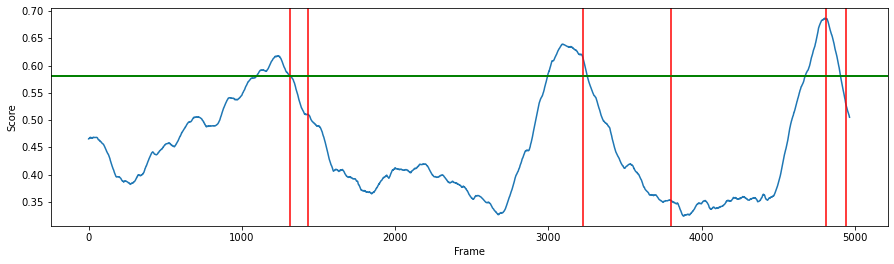

Video: 128


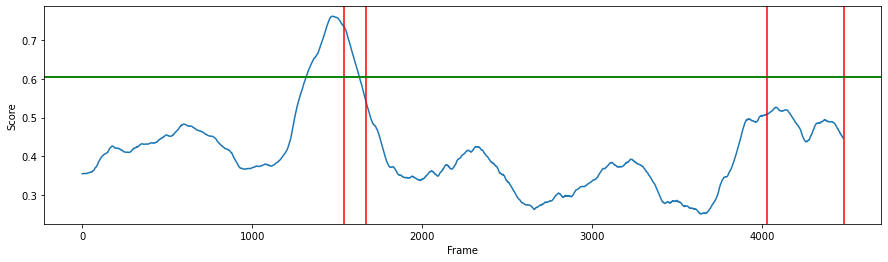

Video: 129


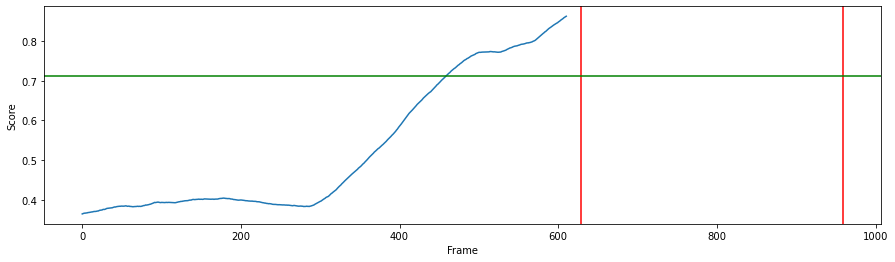

TP: 60 FP: 231 FN: 273
Done Subject 29


In [12]:
logo = LeaveOneGroupOut()
logo.get_n_splits(X, y, groupsLabel)
subject_count = 0
epochs = 10
batch_size = 12
total_gt = 0
metric_fn = MeanAveragePrecision2d(num_classes=1)
p = 0.55 #From our analysis, 0.55 achieved the highest F1-Score
model = SOFTNet()
weight_reset = model.get_weights() #Initial weights

for train_index, test_index in logo.split(X, y, groupsLabel): # Leave One Subject Out
    subject_count+=1
    print('Subject : ' + str(subject_count))
    
    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index] #Get training set
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index] #Get testing set
        
    #Downsampling non expression samples the dataset by 1/2 to reduce dataset bias 
    print('Dataset Labels', Counter(y_train))
    unique, uni_count = np.unique(y_train, return_counts=True) 
    rem_count = int(uni_count.max()*1/2)
    
    #Randomly remove non expression samples (With label 0) from dataset
    rem_index = random.sample([index for index, i in enumerate(y_train) if i==0], rem_count) 
    rem_index += (index for index, i in enumerate(y_train) if i>0)
    rem_index.sort()
    X_train = [X_train[i] for i in rem_index]
    y_train = [y_train[i] for i in rem_index]
    print('After Downsampling Dataset Labels', Counter(y_train))
    
    #Data augmentation to the micro-expression samples only
    if (expression_type == 'micro-expression'):
        X_train, y_train = data_augmentation(X_train, y_train)
        print('After Augmentation Dataset Labels', Counter(y_train))
        
    #Shuffle the training set
    X_train, y_train = shuffling(X_train, y_train)
    
    print('------Initializing SOFTNet-------') #To reset the model at every LOSO testing
    
    path = 'SOFTNet_Weights\\' + dataset_name + '\\' + expression_type + '\\s' + str(subject_count) + '.hdf5'
    model.set_weights(weight_reset) #Reset weights to ensure the model does not have info about current subject
    
#     model.load_weights(path)  #Load Pretrained Weights
    
    model.fit(
        generator(X_train, y_train, batch_size, epochs),
        steps_per_epoch = len(X_train)/batch_size,
        epochs=epochs,
        verbose=1,
        validation_data = generator(X_test, y_test, batch_size),
        validation_steps = len(X_test)/batch_size,
        shuffle=True,
        callbacks=[keras.callbacks.ModelCheckpoint(
            filepath = path,
            save_weights_only=True
        )],
    )
    result = model.predict_generator(
        generator(X_test, y_test, batch_size),
        steps=len(X_test)/batch_size,
        verbose=1
    )
    
    preds, gt, total_gt = spotting(result, total_gt)
    TP, FP, FN = evaluation(preds, gt , total_gt)
    
    print('Done Subject', subject_count)

Final Evaluation

In [13]:
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1_score = (2 * precision * recall) / (precision + recall)

print('Final Result for', dataset_name, expression_type)
print('TP:', TP, 'FP:', FP, 'FN:', FN)
print('Precision = ', round(precision, 4))
print('Recall = ', round(recall, 4))
print('F1-Score = ', round(F1_score, 4))
print("COCO AP@[.5:.95]:", round(metric_fn.value(iou_thresholds=np.round(np.arange(0.5, 1.0, 0.05), 2), mpolicy='soft')['mAP'], 4))

Final Result for SAMMLV macro-expression
TP: 60 FP: 231 FN: 273
Precision =  0.2062
Recall =  0.1802
F1-Score =  0.1923
COCO AP@[.5:.95]: 0.0103


In [14]:
# Result if Pre-trained weights are used

# Final Result for CASME_sq micro-expression
# TP: 21 FP: 252 FN: 36
# Precision =  0.0769
# Recall =  0.3684
# F1-Score =  0.1273
# COCO AP@[.5:.95]: 0.0104

# Final Result for CASME_sq macro-expression
# TP: 92 FP: 343 FN: 208
# Precision =  0.2115
# Recall =  0.3067
# F1-Score =  0.2503
# COCO AP@[.5:.95]: 0.0187

# Final Result for SAMMLV micro-expression
# TP: 41 FP: 323 FN: 118
# Precision =  0.1126
# Recall =  0.2579
# F1-Score =  0.1568
# COCO AP@[.5:.95]: 0.0092

# Final Result for SAMMLV macro-expression
# TP: 60 FP: 231 FN: 273
# Precision =  0.2062
# Recall =  0.1802
# F1-Score =  0.1923
# COCO AP@[.5:.95]: 0.0103